In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

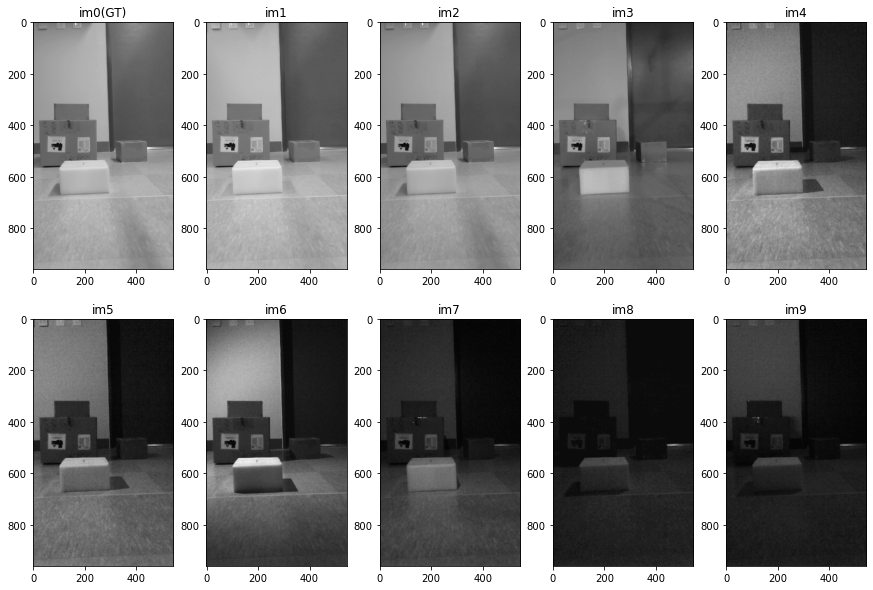

In [2]:
im0 = cv2.imread("./data/test2/2023-12-21-174303.jpg")
im1 = cv2.imread("./data/test2/2023-12-21-174235.jpg")
im2 = cv2.imread("./data/test2/2023-12-21-174239.jpg")
im3 = cv2.imread("./data/test2/2023-12-21-174244.jpg")
im4 = cv2.imread("./data/test2/2023-12-21-174433.jpg")
im5 = cv2.imread("./data/test2/2023-12-21-174430.jpg")
im6 = cv2.imread("./data/test2/2023-12-21-174438.jpg")
im7 = cv2.imread("./data/test2/2023-12-21-174415.jpg")
im8 = cv2.imread("./data/test2/2023-12-21-174248.jpg")
im9 = cv2.imread("./data/test2/2023-12-21-174252.jpg")

im0_gray = cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY)
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
im3_gray = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)
im4_gray = cv2.cvtColor(im4, cv2.COLOR_BGR2GRAY)
im5_gray = cv2.cvtColor(im5, cv2.COLOR_BGR2GRAY)
im6_gray = cv2.cvtColor(im6, cv2.COLOR_BGR2GRAY)
im7_gray = cv2.cvtColor(im7, cv2.COLOR_BGR2GRAY)
im8_gray = cv2.cvtColor(im8, cv2.COLOR_BGR2GRAY)
im9_gray = cv2.cvtColor(im9, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 10))

def visualization(img, idx, title="") :
    plt.subplot(idx[0], idx[1], idx[2])
    plt.title(title)
    plt.imshow(img, cmap='gray')


visualization(im0_gray, (2,5,1), title="im0(GT)")
visualization(im1_gray, (2,5,2), title="im1")
visualization(im2_gray, (2,5,3), title="im2")
visualization(im3_gray, (2,5,4), title="im3")
visualization(im4_gray, (2,5,5), title="im4")
visualization(im5_gray, (2,5,6), title="im5")
visualization(im6_gray, (2,5,7), title="im6")
visualization(im7_gray, (2,5,8), title="im7")
visualization(im8_gray, (2,5,9), title="im8")
visualization(im9_gray, (2,5,10), title="im9")

In [3]:
def contrast_stretching(img) :  
    pixels = np.array(img).flatten()
    std = np.std(pixels)
    min_val = np.min(img)
    max_val = np.max(img)
    stretched_img = (img - min_val) * (255 / (max_val - min_val))
    stretched_img = stretched_img.astype(np.uint8)
    
    pixels = np.array(stretched_img).flatten()
    std_stretched = np.std(pixels)
    print(f"Original intensity std {std:.2f} --> Stretched intensity std {std_stretched:.2f}")
    return stretched_img

def canny(img) : 
    return cv2.Canny(img, 100, 200)


def auto_canny(img, sigma=0.33) : 
#     img = cv2.GaussianBlur(img, (3, 3), 0)
    v = np.median(img)
#     print(f"Average brightness:{np.mean(img):.2f}") # 평균 밝기 계산 
#     print(f"Bright Contrast:{np.std(img):.2f}") # 대조 값
    lower = int(max(0, 1.0 - sigma)*v)
    upper = int(min(255, (1.0 + sigma)*v ))
    print(f"Threshold (lower) {lower} (upper) {upper}")
    edged = cv2.Canny(img, lower, upper)
    return edged

def auto_canny_otsu(image):
    # 오츠의 방법을 사용하여 엣지 검출을 위한 최적의 임계값을 계산
    high_thresh, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5 * high_thresh
    print(low_thresh, high_thresh)

    # Canny 엣지 검출 적용
#     blur = cv2.GaussianBlur(image, (3, 3), 0)
    edged = cv2.Canny(image, low_thresh, high_thresh)

    return edged

def calculate_weighted_gradient(image):
    # 색상 채널 분리
    blue, green, red = cv2.split(image)

    # Sobel 연산자를 각 채널에 적용하여 그래디언트 계산
    grad_x_red = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_red = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=3)
    
    grad_x_green = cv2.Sobel(green, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_green = cv2.Sobel(green, cv2.CV_64F, 0, 1, ksize=3)
    
    grad_x_blue = cv2.Sobel(blue, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_blue = cv2.Sobel(blue, cv2.CV_64F, 0, 1, ksize=3)

    # 각 채널에 대한 그래디언트 크기 계산
    magnitude_red = np.sqrt(grad_x_red**2 + grad_y_red**2)
    magnitude_green = np.sqrt(grad_x_green**2 + grad_y_green**2)
    magnitude_blue = np.sqrt(grad_x_blue**2 + grad_y_blue**2)

    # 가중치 적용
    weighted_magnitude = 0.2 * magnitude_red + 0.6 * magnitude_green + 0.1 * magnitude_blue

    return weighted_magnitude


from sklearn.metrics import roc_auc_score
def calculate_metrics(gt, edge_detected):
    TP = np.sum((gt == 255) & (edge_detected == 255))
    FP = np.sum((gt == 0) & (edge_detected == 255))
    FN = np.sum((gt == 255) & (edge_detected == 0))
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # harmonic mean of recall and precision 
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        
    # auc score 
    gt_binary = ((gt == 255).flatten()).astype(int)
    edge_detected_binary = ((edge_detected == 255).flatten()).astype(int)
    try : 
        auc_score = roc_auc_score(gt_binary, edge_detected_binary)
    except : 
        auc_score = 0.5
    return f1_score, auc_score

## 1. Canny Edge (100, 200) 

In [4]:


edge0 = cv2.Canny(im0_gray, 100, 200)
edge1 = cv2.Canny(im1_gray, 100, 200)
edge2 = cv2.Canny(im2_gray, 100, 200)
edge3 = cv2.Canny(im3_gray, 100, 200)
edge4 = cv2.Canny(im4_gray, 100, 200)
edge5 = cv2.Canny(im5_gray, 100, 200)
edge6 = cv2.Canny(im6_gray, 100, 200)
edge7 = cv2.Canny(im7_gray, 100, 200)
edge8 = cv2.Canny(im8_gray, 100, 200)
edge9 = cv2.Canny(im9_gray, 100, 200)

def print_metrics() :
    r, p = calculate_metrics(edge0, edge1)
    print(f"Edge1 F1-score : {r:.2f} / Auc score : {p:.2f}")

    r, p = calculate_metrics(edge0, edge2)
    print(f"Edge2 F1-score : {r:.2f} / Auc score : {p:.2f}")

    r, p = calculate_metrics(edge0, edge3)
    print(f"Edge3 F1-score : {r:.2f} / Auc score : {p:.2f}")

    r, p = calculate_metrics(edge0, edge4)
    print(f"Edge4 F1-score : {r:.2f} / Auc score : {p:.2f}")

    r, p = calculate_metrics(edge0, edge5)
    print(f"Edge5 F1-score : {r:.2f} / Auc score : {p:.2f}")

    r, p = calculate_metrics(edge0, edge6)
    print(f"Edge6 F1-score : {r:.2f} / Auc score : {p:.2f}")

    r, p = calculate_metrics(edge0, edge7)
    print(f"Edge7 F1-score : {r:.2f} / Auc score : {p:.2f}")

    r, p = calculate_metrics(edge0, edge8)
    print(f"Edge8 F1-score : {r:.2f} / Auc score : {p:.2f}")

    r, p = calculate_metrics(edge0, edge9)
    print(f"Edge9 F1-score : {r:.2f} / Auc score : {p:.2f}")

print("Canny Edge(100, 200) with No F")
print_metrics()

Canny Edge(100, 200) with No F
Edge1 F1-score : 0.56 / Auc score : 0.78
Edge2 F1-score : 0.58 / Auc score : 0.77
Edge3 F1-score : 0.43 / Auc score : 0.70
Edge4 F1-score : 0.05 / Auc score : 0.51
Edge5 F1-score : 0.04 / Auc score : 0.51
Edge6 F1-score : 0.08 / Auc score : 0.53
Edge7 F1-score : 0.00 / Auc score : 0.50
Edge8 F1-score : 0.02 / Auc score : 0.50
Edge9 F1-score : 0.02 / Auc score : 0.51


### Median F

In [5]:
start = time.time()
blur = cv2.medianBlur(im0_gray, 5)
print(f"Processing time : {time.time() - start:.2f}")

Processing time : 0.01


In [6]:
blur = cv2.medianBlur(im0_gray, 5)
edge0 = cv2.Canny(blur, 100, 200)
blur = cv2.medianBlur(im1_gray, 5)
edge1 = cv2.Canny(blur, 100, 200)
blur = cv2.medianBlur(im2_gray, 5)
edge2 = cv2.Canny(blur, 100, 200)
blur = cv2.medianBlur(im3_gray, 5)
edge3 = cv2.Canny(blur, 100, 200)
blur = cv2.medianBlur(im4_gray, 5)
edge4 = cv2.Canny(blur, 100, 200)
blur = cv2.medianBlur(im5_gray, 5)
edge5 = cv2.Canny(blur, 100, 200)
blur = cv2.medianBlur(im6_gray, 5)
edge6 = cv2.Canny(blur, 100, 200)
blur = cv2.medianBlur(im7_gray, 5)
edge7 = cv2.Canny(blur, 100, 200)
blur = cv2.medianBlur(im8_gray, 5)
edge8 = cv2.Canny(blur, 100, 200)
blur = cv2.medianBlur(im9_gray, 5)
edge9 = cv2.Canny(blur, 100, 200)

print("Canny Edge(100, 200) with Median F")
print_metrics()

Canny Edge(100, 200) with Median F
Edge1 F1-score : 0.58 / Auc score : 0.78
Edge2 F1-score : 0.61 / Auc score : 0.79
Edge3 F1-score : 0.45 / Auc score : 0.73
Edge4 F1-score : 0.06 / Auc score : 0.52
Edge5 F1-score : 0.03 / Auc score : 0.51
Edge6 F1-score : 0.08 / Auc score : 0.53
Edge7 F1-score : 0.00 / Auc score : 0.50
Edge8 F1-score : 0.00 / Auc score : 0.50
Edge9 F1-score : 0.00 / Auc score : 0.50


### Gaussian F 

In [7]:
start = time.time()
blur = cv2.GaussianBlur(im0_gray, (5, 5), 0) 
print(f"Processing time : {time.time() - start:.2f}")

Processing time : 0.00


In [8]:
blur = cv2.GaussianBlur(im0_gray, (5, 5), 0) 
edge0 = cv2.Canny(blur, 100, 200)
blur = cv2.GaussianBlur(im1_gray, (5, 5), 0) 
edge1 = cv2.Canny(blur, 100, 200)
blur = cv2.GaussianBlur(im2_gray, (5, 5), 0) 
edge2 = cv2.Canny(blur, 100, 200)
blur = cv2.GaussianBlur(im3_gray, (5, 5), 0) 
edge3 = cv2.Canny(blur, 100, 200)
blur = cv2.GaussianBlur(im4_gray, (5, 5), 0) 
edge4 = cv2.Canny(blur, 100, 200)
blur = cv2.GaussianBlur(im5_gray, (5, 5), 0) 
edge5 = cv2.Canny(blur, 100, 200)
blur = cv2.GaussianBlur(im6_gray, (5, 5), 0) 
edge6 = cv2.Canny(blur, 100, 200)
blur = cv2.GaussianBlur(im7_gray, (5, 5), 0) 
edge7 = cv2.Canny(blur, 100, 200)
blur = cv2.GaussianBlur(im8_gray, (5, 5), 0) 
edge8 = cv2.Canny(blur, 100, 200)
blur = cv2.GaussianBlur(im9_gray, (5, 5), 0) 
edge9 = cv2.Canny(blur, 100, 200)

print("Canny Edge(100, 200) with Gaussian F")
print_metrics()

Canny Edge(100, 200) with Gaussian F
Edge1 F1-score : 0.53 / Auc score : 0.74
Edge2 F1-score : 0.57 / Auc score : 0.75
Edge3 F1-score : 0.37 / Auc score : 0.65
Edge4 F1-score : 0.04 / Auc score : 0.51
Edge5 F1-score : 0.00 / Auc score : 0.50
Edge6 F1-score : 0.03 / Auc score : 0.51
Edge7 F1-score : 0.00 / Auc score : 0.50
Edge8 F1-score : 0.00 / Auc score : 0.50
Edge9 F1-score : 0.00 / Auc score : 0.50


### Non-local Mean Filter

#### h=5, templatewindow=5, searchwindow=7

In [9]:
blur = cv2.fastNlMeansDenoising(im0_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge0 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im1_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge1 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im2_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge2 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im3_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge3 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im4_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge4 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im5_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge5 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im6_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge6 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im7_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge7 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im8_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge8 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im9_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge9 = cv2.Canny(blur, 100, 200)

print("Canny Edge(100, 200) with Non-local mean F")
print("#### h=5, templatewindow=5, searchwindow=7")
print_metrics()

Canny Edge(100, 200) with Non-local mean F
#### h=5, templatewindow=5, searchwindow=7
Edge1 F1-score : 0.57 / Auc score : 0.78
Edge2 F1-score : 0.58 / Auc score : 0.77
Edge3 F1-score : 0.43 / Auc score : 0.70
Edge4 F1-score : 0.05 / Auc score : 0.51
Edge5 F1-score : 0.02 / Auc score : 0.50
Edge6 F1-score : 0.05 / Auc score : 0.52
Edge7 F1-score : 0.00 / Auc score : 0.50
Edge8 F1-score : 0.02 / Auc score : 0.50
Edge9 F1-score : 0.02 / Auc score : 0.51


#### h=7, templatewindow=5, searchwindow=11

In [10]:
blur = cv2.fastNlMeansDenoising(im0_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge0 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im1_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge1 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im2_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge2 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im3_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge3 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im4_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge4 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im5_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge5 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im6_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge6 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im7_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge7 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im8_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge8 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im9_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge9 = cv2.Canny(blur, 100, 200)

print("Canny Edge(100, 200) with Non-local mean F")
print("#### h=7, templatewindow=5, searchwindow=11")
print_metrics()

Canny Edge(100, 200) with Non-local mean F
#### h=7, templatewindow=5, searchwindow=11
Edge1 F1-score : 0.58 / Auc score : 0.79
Edge2 F1-score : 0.60 / Auc score : 0.78
Edge3 F1-score : 0.45 / Auc score : 0.71
Edge4 F1-score : 0.06 / Auc score : 0.52
Edge5 F1-score : 0.02 / Auc score : 0.50
Edge6 F1-score : 0.05 / Auc score : 0.52
Edge7 F1-score : 0.00 / Auc score : 0.50
Edge8 F1-score : 0.00 / Auc score : 0.50
Edge9 F1-score : 0.00 / Auc score : 0.50


#### h=5, templatewindow=3, searchwindow=9

In [11]:
blur = cv2.fastNlMeansDenoising(im0_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge0 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im1_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge1 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im2_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge2 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im3_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge3 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im4_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge4 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im5_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge5 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im6_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge6 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im7_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge7 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im8_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge8 = cv2.Canny(blur, 100, 200)
blur = cv2.fastNlMeansDenoising(im9_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge9 = cv2.Canny(blur, 100, 200)

print("Canny Edge(100, 200) with Non-local mean F")
print("#### h=5, templatewindow=3, searchwindow=9")
print_metrics()

Canny Edge(100, 200) with Non-local mean F
#### h=5, templatewindow=3, searchwindow=9
Edge1 F1-score : 0.57 / Auc score : 0.78
Edge2 F1-score : 0.58 / Auc score : 0.77
Edge3 F1-score : 0.44 / Auc score : 0.70
Edge4 F1-score : 0.06 / Auc score : 0.52
Edge5 F1-score : 0.02 / Auc score : 0.50
Edge6 F1-score : 0.05 / Auc score : 0.52
Edge7 F1-score : 0.00 / Auc score : 0.50
Edge8 F1-score : 0.00 / Auc score : 0.50
Edge9 F1-score : 0.02 / Auc score : 0.51


In [12]:
# 수행 시간 알아보기
start = time.time()
blur = cv2.fastNlMeansDenoising(im0_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge0 = cv2.Canny(blur, 100, 200)

print("#### h=5, templatewindow=5, searchwindow=7")
print(f"Processing time : {time.time() - start:.2f}")

start = time.time()
blur = cv2.fastNlMeansDenoising(im0_gray, None, h=7, templateWindowSize=5, searchWindowSize=11)
edge0 = cv2.Canny(blur, 100, 200)

print("#### h=7, templatewindow=5, searchwindow=11")
print(f"Processing time : {time.time() - start:.2f}")

start = time.time()
blur = cv2.fastNlMeansDenoising(im0_gray, None, h=5, templateWindowSize=3, searchWindowSize=9)
edge0 = cv2.Canny(blur, 100, 200)

print("#### h=5, templatewindow=3, searchwindow=9")
print(f"Processing time : {time.time() - start:.2f}")

#### h=5, templatewindow=5, searchwindow=7
Processing time : 0.08
#### h=7, templatewindow=5, searchwindow=11
Processing time : 0.15
#### h=5, templatewindow=3, searchwindow=9
Processing time : 0.11


## Guided Filter 

In [13]:
start = time.time()

radius = 5  # 필터의 반경
eps = 0.1   # 정규화 항


guide = im0_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im0_gray, radius=radius, eps=eps)
edge0 = cv2.Canny(blur, 100, 200)

print(f"Processing time : {time.time() - start:.2f}")

Processing time : 0.03


In [14]:

guide = im0_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im0_gray, radius=radius, eps=eps)
edge0 = cv2.Canny(blur, 100, 200)

guide = im1_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im1_gray, radius=radius, eps=eps)
edge1 = cv2.Canny(blur, 100, 200)

guide = im2_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im2_gray, radius=radius, eps=eps)
edge2 = cv2.Canny(blur, 100, 200)

guide = im3_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im3_gray, radius=radius, eps=eps)
edge3 = cv2.Canny(blur, 100, 200)

guide = im4_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im4_gray, radius=radius, eps=eps)
edge4 = cv2.Canny(blur, 100, 200)

guide = im5_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im5_gray, radius=radius, eps=eps)
edge5 = cv2.Canny(blur, 100, 200)

guide = im6_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im6_gray, radius=radius, eps=eps)
edge6 = cv2.Canny(blur, 100, 200)

guide = im7_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im7_gray, radius=radius, eps=eps)
edge7 = cv2.Canny(blur, 100, 200)

guide = im8_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im8_gray, radius=radius, eps=eps)
edge8 = cv2.Canny(blur, 100, 200)

guide = im9_gray.copy()
blur = cv2.ximgproc.guidedFilter(guide=guide, src=im9_gray, radius=radius, eps=eps)
edge9 = cv2.Canny(blur, 100, 200)

print("Canny Edge(100, 200) with Guided Filter (self guide img)")
print(f"#### radius={radius}, eps={eps}")
print_metrics()

Canny Edge(100, 200) with Guided Filter (self guide img)
#### radius=5, eps=0.1
Edge1 F1-score : 0.56 / Auc score : 0.78
Edge2 F1-score : 0.58 / Auc score : 0.77
Edge3 F1-score : 0.43 / Auc score : 0.70
Edge4 F1-score : 0.05 / Auc score : 0.51
Edge5 F1-score : 0.04 / Auc score : 0.51
Edge6 F1-score : 0.08 / Auc score : 0.53
Edge7 F1-score : 0.00 / Auc score : 0.50
Edge8 F1-score : 0.02 / Auc score : 0.50
Edge9 F1-score : 0.02 / Auc score : 0.51


In [15]:
radius = 5  # 필터의 반경
eps = 0.1   # 정규화 항

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im0_gray, radius=radius, eps=eps)
edge0 = cv2.Canny(blur, 100, 200)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im1_gray, radius=radius, eps=eps)
edge1 = cv2.Canny(blur, 100, 200)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im2_gray, radius=radius, eps=eps)
edge2 = cv2.Canny(blur, 100, 200)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im3_gray, radius=radius, eps=eps)
edge3 = cv2.Canny(blur, 100, 200)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im4_gray, radius=radius, eps=eps)
edge4 = cv2.Canny(blur, 100, 200)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im5_gray, radius=radius, eps=eps)
edge5 = cv2.Canny(blur, 100, 200)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im6_gray, radius=radius, eps=eps)
edge6 = cv2.Canny(blur, 100, 200)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im7_gray, radius=radius, eps=eps)
edge7 = cv2.Canny(blur, 100, 200)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im8_gray, radius=radius, eps=eps)
edge8 = cv2.Canny(blur, 100, 200)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im9_gray, radius=radius, eps=eps)
edge9 = cv2.Canny(blur, 100, 200)

print("Canny Edge(100, 200) with Guided Filter (lightest guide img)")
print(f"#### radius={radius}, eps={eps}")
print_metrics()

Canny Edge(100, 200) with Guided Filter (lightest guide img)
#### radius=5, eps=0.1
Edge1 F1-score : 0.81 / Auc score : 0.89
Edge2 F1-score : 0.85 / Auc score : 0.89
Edge3 F1-score : 0.65 / Auc score : 0.79
Edge4 F1-score : 0.24 / Auc score : 0.57
Edge5 F1-score : 0.05 / Auc score : 0.51
Edge6 F1-score : 0.29 / Auc score : 0.59
Edge7 F1-score : 0.04 / Auc score : 0.51
Edge8 F1-score : 0.09 / Auc score : 0.52
Edge9 F1-score : 0.09 / Auc score : 0.52


## contrast stretching 

## 2. Auto Canny with Median 

In [16]:
edge0 = auto_canny(im0_gray)
edge1 = auto_canny(im1_gray)
edge2 = auto_canny(im2_gray)
edge3 = auto_canny(im3_gray)
edge4 = auto_canny(im4_gray)
edge5 = auto_canny(im5_gray)
edge6 = auto_canny(im6_gray)
edge7 = auto_canny(im7_gray)
edge8 = auto_canny(im8_gray)
edge9 = auto_canny(im9_gray)

print("Auto canny")
print_metrics()

Threshold (lower) 105 (upper) 208
Threshold (lower) 106 (upper) 211
Threshold (lower) 96 (upper) 191
Threshold (lower) 71 (upper) 142
Threshold (lower) 36 (upper) 73
Threshold (lower) 32 (upper) 63
Threshold (lower) 30 (upper) 61
Threshold (lower) 24 (upper) 49
Threshold (lower) 14 (upper) 29
Threshold (lower) 17 (upper) 34
Auto canny
Edge1 F1-score : 0.56 / Auc score : 0.77
Edge2 F1-score : 0.59 / Auc score : 0.79
Edge3 F1-score : 0.41 / Auc score : 0.72
Edge4 F1-score : 0.14 / Auc score : 0.56
Edge5 F1-score : 0.14 / Auc score : 0.56
Edge6 F1-score : 0.12 / Auc score : 0.57
Edge7 F1-score : 0.14 / Auc score : 0.57
Edge8 F1-score : 0.14 / Auc score : 0.55
Edge9 F1-score : 0.35 / Auc score : 0.66


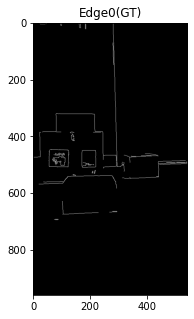

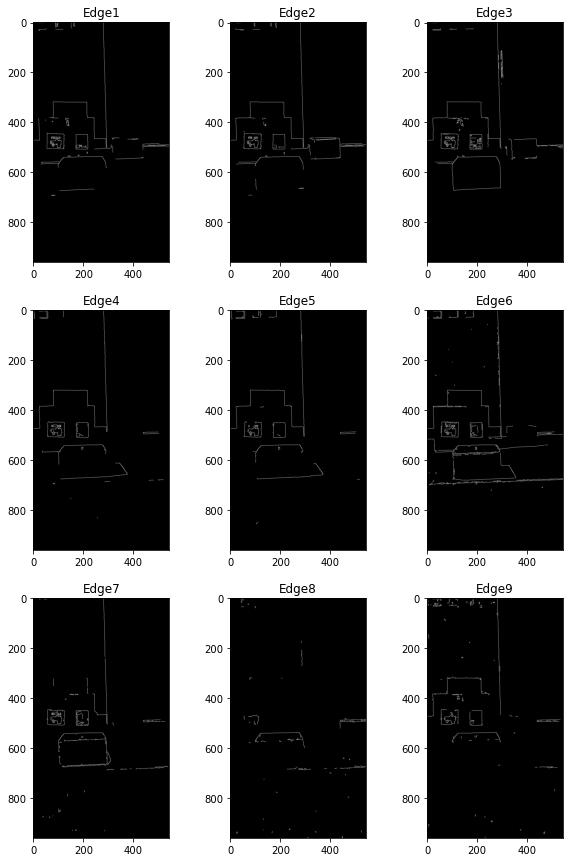

In [17]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### Median F

In [18]:
blur = cv2.medianBlur(im0_gray, 3)
edge0 = auto_canny(blur)
blur = cv2.medianBlur(im1_gray, 3)
edge1 = auto_canny(blur)
blur = cv2.medianBlur(im2_gray, 3)
edge2 = auto_canny(blur)
blur = cv2.medianBlur(im3_gray, 3)
edge3 = auto_canny(blur)
blur = cv2.medianBlur(im4_gray, 3)
edge4 = auto_canny(blur)
blur = cv2.medianBlur(im5_gray, 3)
edge5 = auto_canny(blur)
blur = cv2.medianBlur(im6_gray, 3)
edge6 = auto_canny(blur)
blur = cv2.medianBlur(im7_gray, 3)
edge7 = auto_canny(blur)
blur = cv2.medianBlur(im8_gray, 3)
edge8 = auto_canny(blur)
blur = cv2.medianBlur(im9_gray, 3)
edge9 = auto_canny(blur)

print("Auto canny & Median F 3x3")
print_metrics()

Threshold (lower) 105 (upper) 208
Threshold (lower) 106 (upper) 211
Threshold (lower) 96 (upper) 191
Threshold (lower) 71 (upper) 142
Threshold (lower) 36 (upper) 73
Threshold (lower) 32 (upper) 63
Threshold (lower) 30 (upper) 61
Threshold (lower) 24 (upper) 49
Threshold (lower) 14 (upper) 29
Threshold (lower) 17 (upper) 34
Auto canny & Median F 3x3
Edge1 F1-score : 0.60 / Auc score : 0.79
Edge2 F1-score : 0.59 / Auc score : 0.78
Edge3 F1-score : 0.42 / Auc score : 0.74
Edge4 F1-score : 0.16 / Auc score : 0.58
Edge5 F1-score : 0.15 / Auc score : 0.57
Edge6 F1-score : 0.11 / Auc score : 0.57
Edge7 F1-score : 0.15 / Auc score : 0.57
Edge8 F1-score : 0.19 / Auc score : 0.56
Edge9 F1-score : 0.42 / Auc score : 0.69


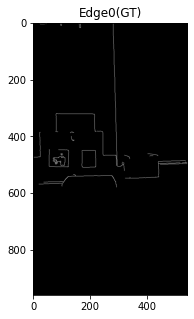

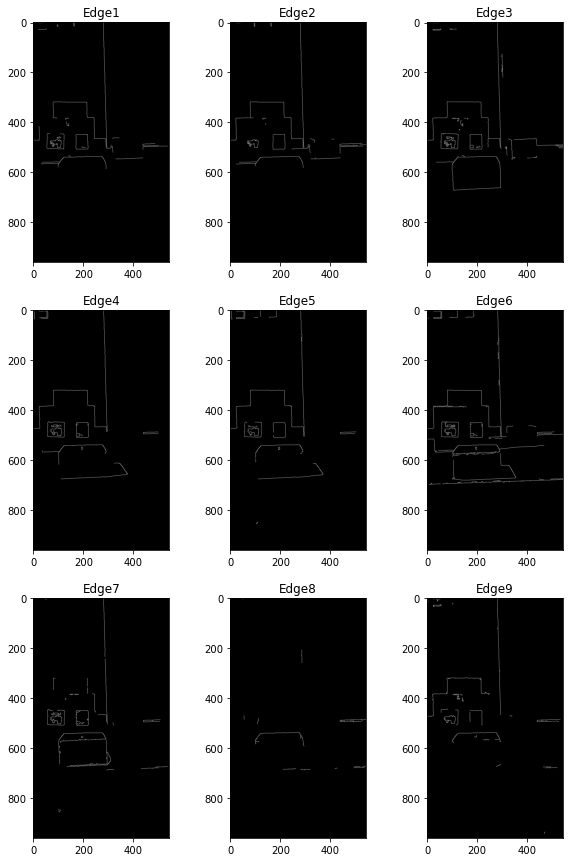

In [19]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

In [20]:
blur = cv2.medianBlur(im0_gray, 5)
edge0 = auto_canny(blur)
blur = cv2.medianBlur(im1_gray, 5)
edge1 = auto_canny(blur)
blur = cv2.medianBlur(im2_gray, 5)
edge2 = auto_canny(blur)
blur = cv2.medianBlur(im3_gray, 5)
edge3 = auto_canny(blur)
blur = cv2.medianBlur(im4_gray, 5)
edge4 = auto_canny(blur)
blur = cv2.medianBlur(im5_gray, 5)
edge5 = auto_canny(blur)
blur = cv2.medianBlur(im6_gray, 5)
edge6 = auto_canny(blur)
blur = cv2.medianBlur(im7_gray, 5)
edge7 = auto_canny(blur)
blur = cv2.medianBlur(im8_gray, 5)
edge8 = auto_canny(blur)
blur = cv2.medianBlur(im9_gray, 5)
edge9 = auto_canny(blur)

print("Auto canny & Median F 5x5")
print_metrics()

Threshold (lower) 105 (upper) 208
Threshold (lower) 106 (upper) 211
Threshold (lower) 96 (upper) 191
Threshold (lower) 71 (upper) 142
Threshold (lower) 36 (upper) 73
Threshold (lower) 32 (upper) 63
Threshold (lower) 30 (upper) 61
Threshold (lower) 24 (upper) 49
Threshold (lower) 14 (upper) 29
Threshold (lower) 17 (upper) 34
Auto canny & Median F 5x5
Edge1 F1-score : 0.60 / Auc score : 0.78
Edge2 F1-score : 0.60 / Auc score : 0.80
Edge3 F1-score : 0.44 / Auc score : 0.75
Edge4 F1-score : 0.15 / Auc score : 0.58
Edge5 F1-score : 0.14 / Auc score : 0.57
Edge6 F1-score : 0.10 / Auc score : 0.57
Edge7 F1-score : 0.13 / Auc score : 0.57
Edge8 F1-score : 0.20 / Auc score : 0.56
Edge9 F1-score : 0.49 / Auc score : 0.73


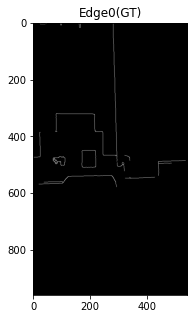

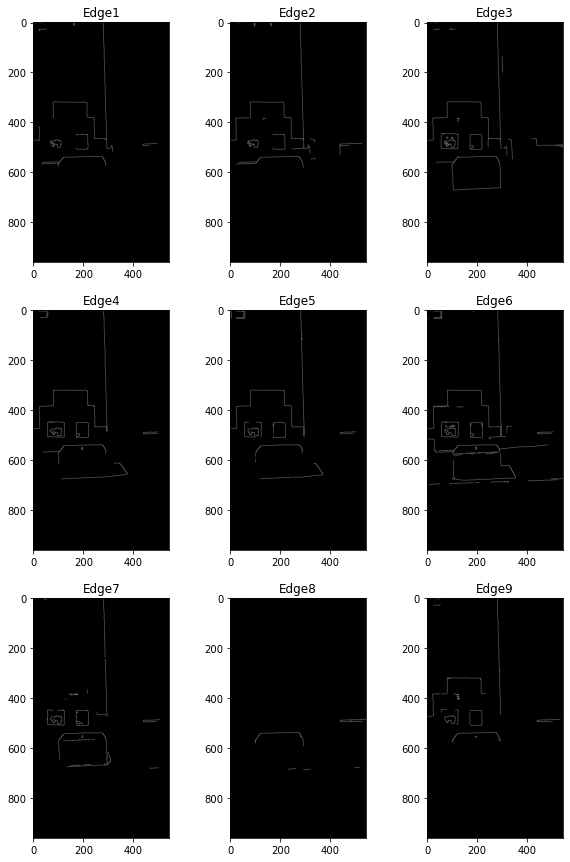

In [21]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

In [22]:
blur = cv2.GaussianBlur(im0_gray, (3, 3), 0) 
edge0 = auto_canny(blur)
blur = cv2.GaussianBlur(im1_gray, (3, 3), 0) 
edge1 = auto_canny(blur)
blur = cv2.GaussianBlur(im2_gray, (3, 3), 0) 
edge2 = auto_canny(blur)
blur = cv2.GaussianBlur(im3_gray, (3, 3), 0) 
edge3 = auto_canny(blur)
blur = cv2.GaussianBlur(im4_gray, (3, 3), 0) 
edge4 = auto_canny(blur)
blur = cv2.GaussianBlur(im5_gray, (3, 3), 0) 
edge5 = auto_canny(blur)
blur = cv2.GaussianBlur(im6_gray, (3, 3), 0) 
edge6 = auto_canny(blur)
blur = cv2.GaussianBlur(im7_gray, (3, 3), 0) 
edge7 = auto_canny(blur)
blur = cv2.GaussianBlur(im8_gray, (3, 3), 0) 
edge8 = auto_canny(blur)
blur = cv2.GaussianBlur(im9_gray, (3, 3), 0) 
edge9 = auto_canny(blur)

print("Auto canny & Gauss F 3x3")
print_metrics()

Threshold (lower) 105 (upper) 208
Threshold (lower) 106 (upper) 211
Threshold (lower) 96 (upper) 191
Threshold (lower) 71 (upper) 142
Threshold (lower) 36 (upper) 73
Threshold (lower) 32 (upper) 63
Threshold (lower) 31 (upper) 62
Threshold (lower) 24 (upper) 49
Threshold (lower) 14 (upper) 29
Threshold (lower) 17 (upper) 34
Auto canny & Gauss F 3x3
Edge1 F1-score : 0.57 / Auc score : 0.77
Edge2 F1-score : 0.61 / Auc score : 0.82
Edge3 F1-score : 0.40 / Auc score : 0.74
Edge4 F1-score : 0.14 / Auc score : 0.57
Edge5 F1-score : 0.15 / Auc score : 0.57
Edge6 F1-score : 0.09 / Auc score : 0.56
Edge7 F1-score : 0.12 / Auc score : 0.56
Edge8 F1-score : 0.19 / Auc score : 0.56
Edge9 F1-score : 0.46 / Auc score : 0.70


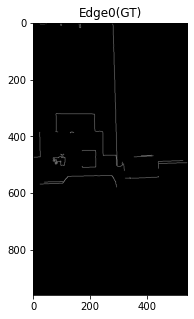

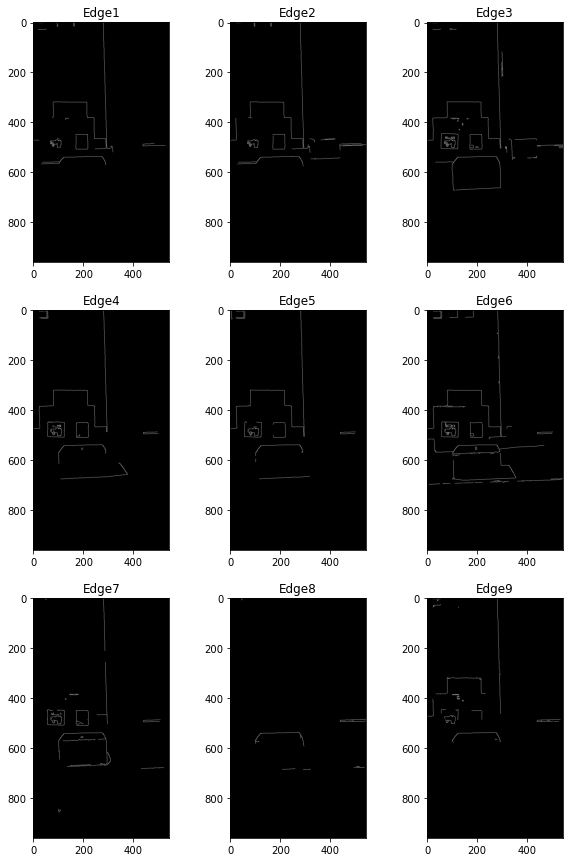

In [23]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

In [24]:
blur = cv2.GaussianBlur(im0_gray, (5, 5), 0) 
edge0 = auto_canny(blur)
blur = cv2.GaussianBlur(im1_gray, (5, 5), 0) 
edge1 = auto_canny(blur)
blur = cv2.GaussianBlur(im2_gray, (5, 5), 0) 
edge2 = auto_canny(blur)
blur = cv2.GaussianBlur(im3_gray, (5, 5), 0) 
edge3 = auto_canny(blur)
blur = cv2.GaussianBlur(im4_gray, (5, 5), 0) 
edge4 = auto_canny(blur)
blur = cv2.GaussianBlur(im5_gray, (5, 5), 0) 
edge5 = auto_canny(blur)
blur = cv2.GaussianBlur(im6_gray, (5, 5), 0) 
edge6 = auto_canny(blur)
blur = cv2.GaussianBlur(im7_gray, (5, 5), 0) 
edge7 = auto_canny(blur)
blur = cv2.GaussianBlur(im8_gray, (5, 5), 0) 
edge8 = auto_canny(blur)
blur = cv2.GaussianBlur(im9_gray, (5, 5), 0) 
edge9 = auto_canny(blur)

print("Auto canny & Gauss F 5x5")
print_metrics()

Threshold (lower) 105 (upper) 208
Threshold (lower) 106 (upper) 211
Threshold (lower) 96 (upper) 191
Threshold (lower) 71 (upper) 142
Threshold (lower) 36 (upper) 73
Threshold (lower) 32 (upper) 63
Threshold (lower) 31 (upper) 62
Threshold (lower) 24 (upper) 49
Threshold (lower) 14 (upper) 29
Threshold (lower) 17 (upper) 34
Auto canny & Gauss F 5x5
Edge1 F1-score : 0.59 / Auc score : 0.77
Edge2 F1-score : 0.62 / Auc score : 0.81
Edge3 F1-score : 0.39 / Auc score : 0.76
Edge4 F1-score : 0.10 / Auc score : 0.56
Edge5 F1-score : 0.10 / Auc score : 0.55
Edge6 F1-score : 0.08 / Auc score : 0.56
Edge7 F1-score : 0.14 / Auc score : 0.57
Edge8 F1-score : 0.25 / Auc score : 0.58
Edge9 F1-score : 0.39 / Auc score : 0.69


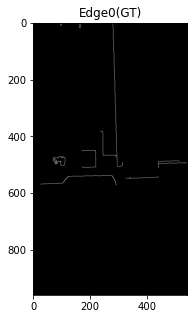

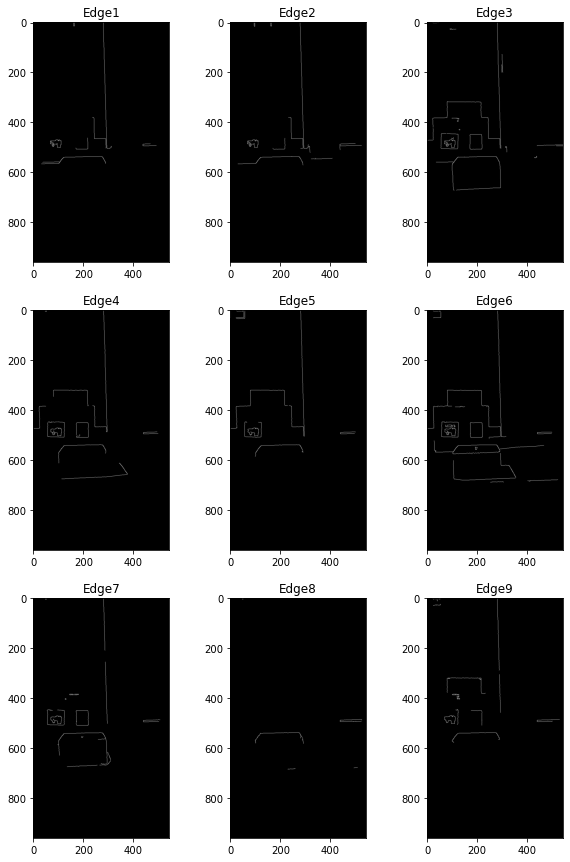

In [25]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### Non-local F 

In [26]:
blur = cv2.fastNlMeansDenoising(im0_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge0 = auto_canny(blur)
blur = cv2.fastNlMeansDenoising(im1_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge1 = auto_canny(blur)
blur = cv2.fastNlMeansDenoising(im2_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge2 = auto_canny(blur)
blur = cv2.fastNlMeansDenoising(im3_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge3 = auto_canny(blur)
blur = cv2.fastNlMeansDenoising(im4_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge4 = auto_canny(blur)
blur = cv2.fastNlMeansDenoising(im5_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge5 = auto_canny(blur)
blur = cv2.fastNlMeansDenoising(im6_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge6 = auto_canny(blur)
blur = cv2.fastNlMeansDenoising(im7_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge7 = auto_canny(blur)
blur = cv2.fastNlMeansDenoising(im8_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge8 = auto_canny(blur)
blur = cv2.fastNlMeansDenoising(im9_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge9 = auto_canny(blur)

print("Auto Canny with Non-local mean F")
print("#### h=5, templatewindow=5, searchwindow=7")
print_metrics()

Threshold (lower) 105 (upper) 208
Threshold (lower) 106 (upper) 211
Threshold (lower) 96 (upper) 191
Threshold (lower) 71 (upper) 142
Threshold (lower) 36 (upper) 73
Threshold (lower) 32 (upper) 63
Threshold (lower) 31 (upper) 62
Threshold (lower) 24 (upper) 49
Threshold (lower) 14 (upper) 29
Threshold (lower) 17 (upper) 34
Auto Canny with Non-local mean F
#### h=5, templatewindow=5, searchwindow=7
Edge1 F1-score : 0.58 / Auc score : 0.78
Edge2 F1-score : 0.59 / Auc score : 0.79
Edge3 F1-score : 0.44 / Auc score : 0.73
Edge4 F1-score : 0.15 / Auc score : 0.56
Edge5 F1-score : 0.13 / Auc score : 0.55
Edge6 F1-score : 0.11 / Auc score : 0.56
Edge7 F1-score : 0.12 / Auc score : 0.55
Edge8 F1-score : 0.13 / Auc score : 0.54
Edge9 F1-score : 0.34 / Auc score : 0.62


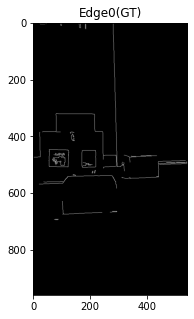

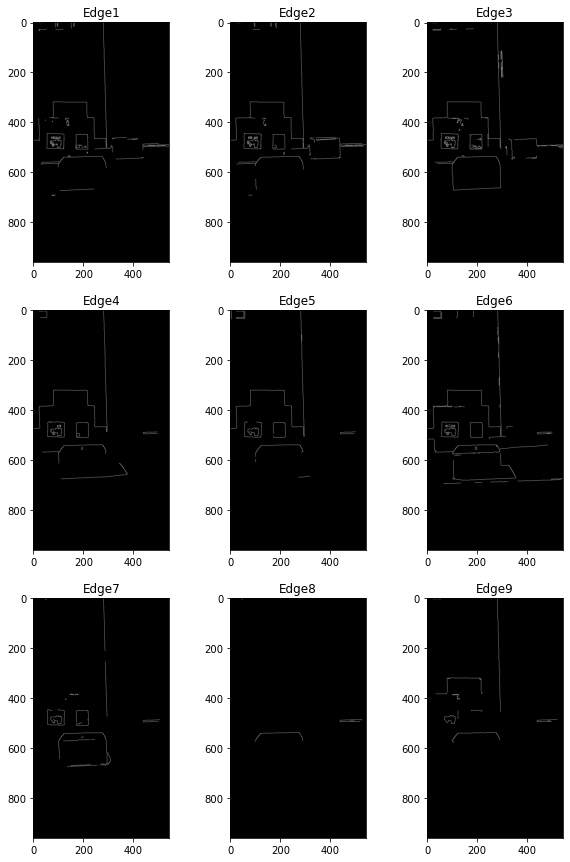

In [27]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### guided F

In [28]:
guide = im0_gray.copy()

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im0_gray, radius=radius, eps=eps)
edge0 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im1_gray, radius=radius, eps=eps)
edge1 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im2_gray, radius=radius, eps=eps)
edge2 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im3_gray, radius=radius, eps=eps)
edge3 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im4_gray, radius=radius, eps=eps)
edge4 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im5_gray, radius=radius, eps=eps)
edge5 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im6_gray, radius=radius, eps=eps)
edge6 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im7_gray, radius=radius, eps=eps)
edge7 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im8_gray, radius=radius, eps=eps)
edge8 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im9_gray, radius=radius, eps=eps)
edge9 = auto_canny(blur)

print("Auto canny with Guided Filter (lightest guide img)")
print(f"#### radius={radius}, eps={eps}")
print_metrics()

Threshold (lower) 105 (upper) 208
Threshold (lower) 106 (upper) 211
Threshold (lower) 96 (upper) 191
Threshold (lower) 71 (upper) 142
Threshold (lower) 36 (upper) 73
Threshold (lower) 32 (upper) 63
Threshold (lower) 31 (upper) 62
Threshold (lower) 24 (upper) 49
Threshold (lower) 14 (upper) 29
Threshold (lower) 17 (upper) 34
Auto canny with Guided Filter (lightest guide img)
#### radius=5, eps=0.1
Edge1 F1-score : 0.84 / Auc score : 0.88
Edge2 F1-score : 0.90 / Auc score : 0.93
Edge3 F1-score : 0.72 / Auc score : 0.83
Edge4 F1-score : 0.68 / Auc score : 0.79
Edge5 F1-score : 0.66 / Auc score : 0.77
Edge6 F1-score : 0.58 / Auc score : 0.82
Edge7 F1-score : 0.60 / Auc score : 0.76
Edge8 F1-score : 0.38 / Auc score : 0.63
Edge9 F1-score : 0.68 / Auc score : 0.78


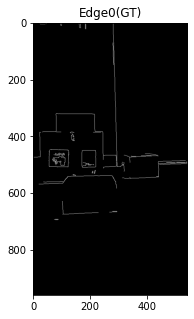

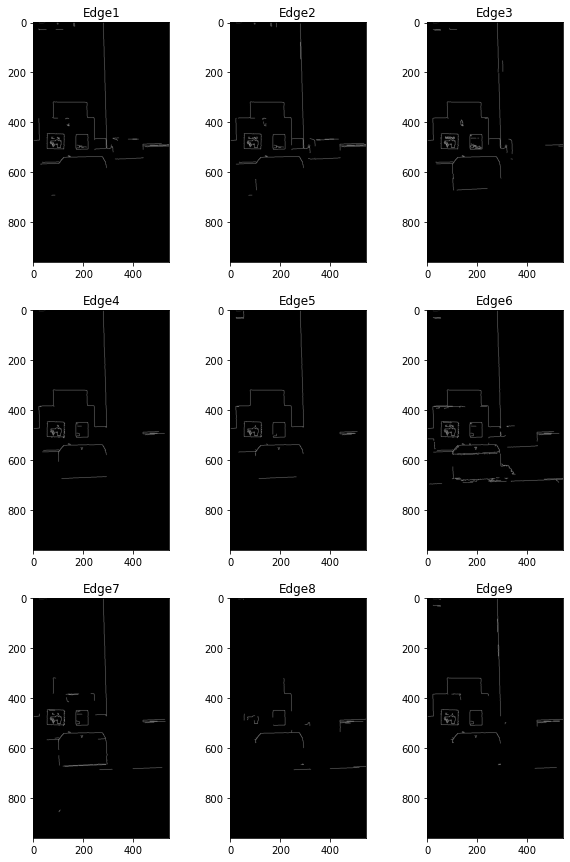

In [29]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### Contrast Stretching 

In [30]:
stretched = contrast_stretching(im0_gray)
edge0 = auto_canny(stretched)
stretched = contrast_stretching(im1_gray)
edge1 = auto_canny(stretched)
stretched = contrast_stretching(im2_gray)
edge2 = auto_canny(stretched)
stretched = contrast_stretching(im3_gray)
edge3 = auto_canny(stretched)
stretched = contrast_stretching(im4_gray)
edge4 = auto_canny(stretched)
stretched = contrast_stretching(im5_gray)
edge5 = auto_canny(stretched)
stretched = contrast_stretching(im6_gray)
edge6 = auto_canny(stretched)
stretched = contrast_stretching(im7_gray)
edge7 = auto_canny(stretched)
stretched = contrast_stretching(im8_gray)
edge8 = auto_canny(stretched)
stretched = contrast_stretching(im9_gray)
edge9 = auto_canny(stretched)

print("Auto canny with Contrast stretching")
print_metrics()

Original intensity std 32.23 --> Stretched intensity std 35.41
Threshold (lower) 103 (upper) 204
Original intensity std 35.78 --> Stretched intensity std 42.04
Threshold (lower) 112 (upper) 223
Original intensity std 29.81 --> Stretched intensity std 33.63
Threshold (lower) 95 (upper) 190
Original intensity std 26.80 --> Stretched intensity std 30.93
Threshold (lower) 62 (upper) 123
Original intensity std 18.98 --> Stretched intensity std 50.46
Threshold (lower) 79 (upper) 158
Original intensity std 15.94 --> Stretched intensity std 43.28
Threshold (lower) 62 (upper) 125
Original intensity std 26.74 --> Stretched intensity std 49.74
Threshold (lower) 43 (upper) 86
Original intensity std 14.85 --> Stretched intensity std 27.04
Threshold (lower) 28 (upper) 57
Original intensity std 4.30 --> Stretched intensity std 12.17
Threshold (lower) 18 (upper) 37
Original intensity std 9.20 --> Stretched intensity std 19.42
Threshold (lower) 18 (upper) 35
Auto canny with Contrast stretching
Edge1 F1

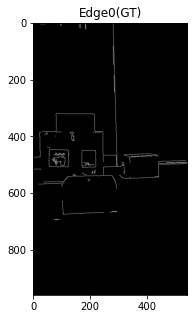

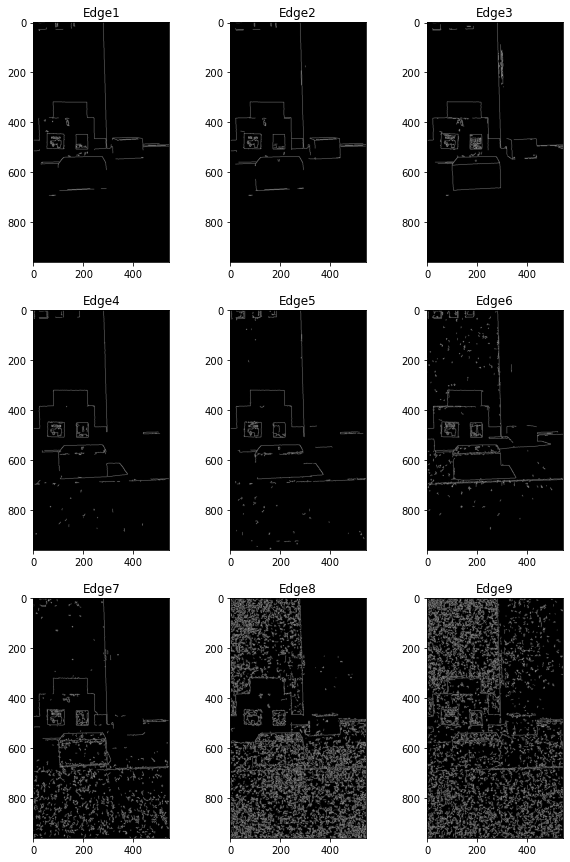

In [31]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### Contrast stretching + Median F

In [32]:
blur = cv2.medianBlur(im0_gray, 3)
stretched = contrast_stretching(blur)
edge0 = auto_canny(stretched)
blur = cv2.medianBlur(im1_gray, 3)
stretched = contrast_stretching(blur)
edge1 = auto_canny(stretched)
blur = cv2.medianBlur(im2_gray, 3)
stretched = contrast_stretching(blur)
edge2 = auto_canny(stretched)
blur = cv2.medianBlur(im3_gray, 3)
stretched = contrast_stretching(blur)
edge3 = auto_canny(stretched)
blur = cv2.medianBlur(im4_gray, 3)
stretched = contrast_stretching(blur)
edge4 = auto_canny(stretched)
blur = cv2.medianBlur(im5_gray, 3)
stretched = contrast_stretching(blur)
edge5 = auto_canny(stretched)
blur = cv2.medianBlur(im6_gray, 3)
stretched = contrast_stretching(blur)
edge6 = auto_canny(stretched)
blur = cv2.medianBlur(im7_gray, 3)
stretched = contrast_stretching(blur)
edge7 = auto_canny(stretched)
blur = cv2.medianBlur(im8_gray, 3)
stretched = contrast_stretching(blur)
edge8 = auto_canny(stretched)
blur = cv2.medianBlur(im9_gray, 3)
stretched = contrast_stretching(blur)
edge9 = auto_canny(stretched)

print("Auto canny with Contrast stretching + Median F")
print_metrics()

Original intensity std 32.12 --> Stretched intensity std 38.27
Threshold (lower) 104 (upper) 207
Original intensity std 35.69 --> Stretched intensity std 45.97
Threshold (lower) 112 (upper) 223
Original intensity std 29.71 --> Stretched intensity std 35.41
Threshold (lower) 94 (upper) 187
Original intensity std 26.72 --> Stretched intensity std 32.60
Threshold (lower) 62 (upper) 123
Original intensity std 18.94 --> Stretched intensity std 55.56
Threshold (lower) 78 (upper) 155
Original intensity std 15.90 --> Stretched intensity std 51.33
Threshold (lower) 71 (upper) 140
Original intensity std 26.70 --> Stretched intensity std 53.39
Threshold (lower) 40 (upper) 81
Original intensity std 14.81 --> Stretched intensity std 34.06
Threshold (lower) 34 (upper) 69
Original intensity std 4.26 --> Stretched intensity std 17.78
Threshold (lower) 24 (upper) 49
Original intensity std 9.16 --> Stretched intensity std 23.84
Threshold (lower) 20 (upper) 41
Auto canny with Contrast stretching + Median

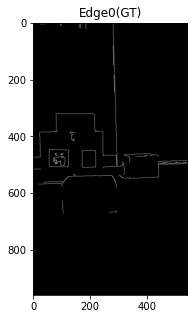

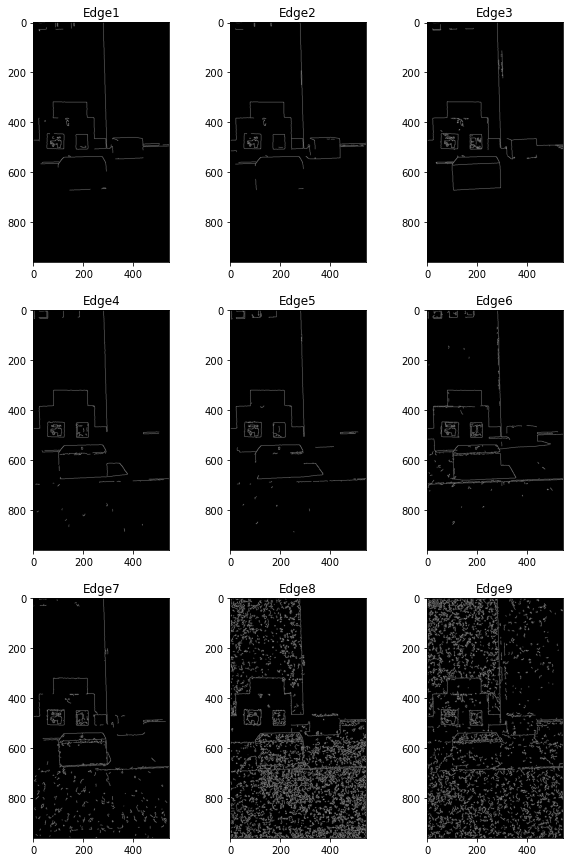

In [33]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

In [34]:
blur = cv2.medianBlur(im0_gray, 5)
stretched = contrast_stretching(blur)
edge0 = auto_canny(stretched)
blur = cv2.medianBlur(im1_gray, 5)
stretched = contrast_stretching(blur)
edge1 = auto_canny(stretched)
blur = cv2.medianBlur(im2_gray, 5)
stretched = contrast_stretching(blur)
edge2 = auto_canny(stretched)
blur = cv2.medianBlur(im3_gray, 5)
stretched = contrast_stretching(blur)
edge3 = auto_canny(stretched)
blur = cv2.medianBlur(im4_gray, 5)
stretched = contrast_stretching(blur)
edge4 = auto_canny(stretched)
blur = cv2.medianBlur(im5_gray, 5)
stretched = contrast_stretching(blur)
edge5 = auto_canny(stretched)
blur = cv2.medianBlur(im6_gray, 5)
stretched = contrast_stretching(blur)
edge6 = auto_canny(stretched)
blur = cv2.medianBlur(im7_gray, 5)
stretched = contrast_stretching(blur)
edge7 = auto_canny(stretched)
blur = cv2.medianBlur(im8_gray, 5)
stretched = contrast_stretching(blur)
edge8 = auto_canny(stretched)
blur = cv2.medianBlur(im9_gray, 5)
stretched = contrast_stretching(blur)
edge9 = auto_canny(stretched)

print("Auto canny with Contrast stretching + Median F")
print_metrics()

Original intensity std 32.04 --> Stretched intensity std 38.91
Threshold (lower) 104 (upper) 207
Original intensity std 35.62 --> Stretched intensity std 47.79
Threshold (lower) 115 (upper) 230
Original intensity std 29.64 --> Stretched intensity std 36.00
Threshold (lower) 95 (upper) 190
Original intensity std 26.66 --> Stretched intensity std 33.33
Threshold (lower) 61 (upper) 122
Original intensity std 18.90 --> Stretched intensity std 56.20
Threshold (lower) 79 (upper) 156
Original intensity std 15.87 --> Stretched intensity std 60.36
Threshold (lower) 83 (upper) 166
Original intensity std 26.65 --> Stretched intensity std 54.77
Threshold (lower) 40 (upper) 81
Original intensity std 14.77 --> Stretched intensity std 49.55
Threshold (lower) 48 (upper) 97
Original intensity std 4.22 --> Stretched intensity std 18.89
Threshold (lower) 20 (upper) 41
Original intensity std 9.12 --> Stretched intensity std 35.78
Threshold (lower) 28 (upper) 57
Auto canny with Contrast stretching + Median

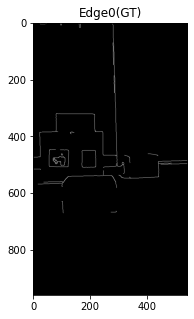

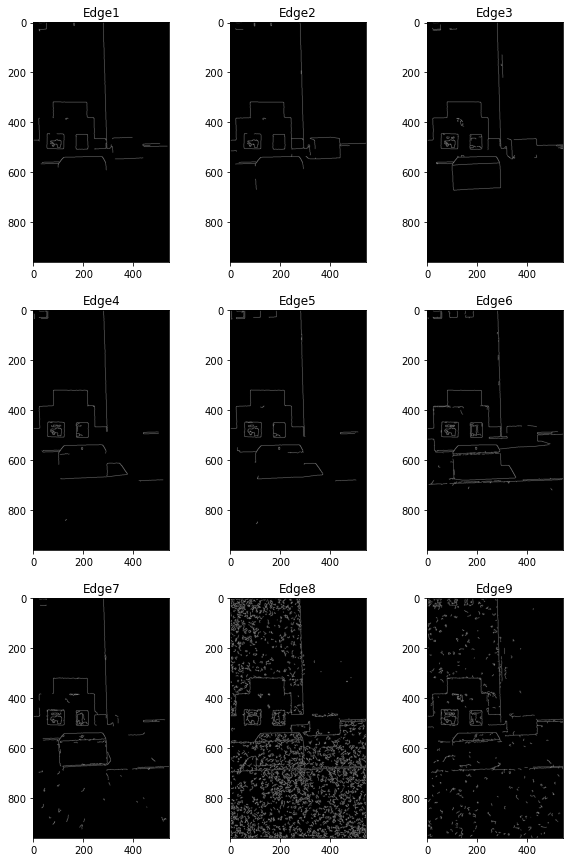

In [35]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### contrast stretching + Gaussian F 

In [36]:
blur = cv2.GaussianBlur(im0_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge0 = auto_canny(stretched)
blur = cv2.GaussianBlur(im1_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge1 = auto_canny(stretched)
blur = cv2.GaussianBlur(im2_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge2 = auto_canny(stretched)
blur = cv2.GaussianBlur(im3_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge3 = auto_canny(stretched)
blur = cv2.GaussianBlur(im4_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge4 = auto_canny(stretched)
blur = cv2.GaussianBlur(im5_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge5 = auto_canny(stretched)
blur = cv2.GaussianBlur(im6_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge6 = auto_canny(stretched)
blur = cv2.GaussianBlur(im7_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge7 = auto_canny(stretched)
blur = cv2.GaussianBlur(im8_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge8 = auto_canny(stretched)
blur = cv2.GaussianBlur(im9_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge9 = auto_canny(stretched)

print("Auto canny with Contrast stretching + Gaussian F")
print_metrics()

Original intensity std 32.06 --> Stretched intensity std 38.38
Threshold (lower) 104 (upper) 207
Original intensity std 35.62 --> Stretched intensity std 45.42
Threshold (lower) 112 (upper) 223
Original intensity std 29.66 --> Stretched intensity std 35.34
Threshold (lower) 94 (upper) 187
Original intensity std 26.65 --> Stretched intensity std 32.37
Threshold (lower) 62 (upper) 123
Original intensity std 18.92 --> Stretched intensity std 54.18
Threshold (lower) 78 (upper) 155
Original intensity std 15.89 --> Stretched intensity std 49.41
Threshold (lower) 68 (upper) 135
Original intensity std 26.66 --> Stretched intensity std 52.78
Threshold (lower) 43 (upper) 86
Original intensity std 14.81 --> Stretched intensity std 36.72
Threshold (lower) 37 (upper) 74
Original intensity std 4.26 --> Stretched intensity std 16.02
Threshold (lower) 20 (upper) 39
Original intensity std 9.16 --> Stretched intensity std 24.07
Threshold (lower) 18 (upper) 37
Auto canny with Contrast stretching + Gaussi

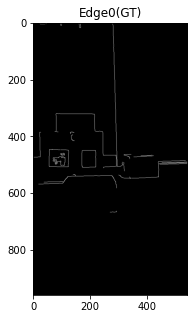

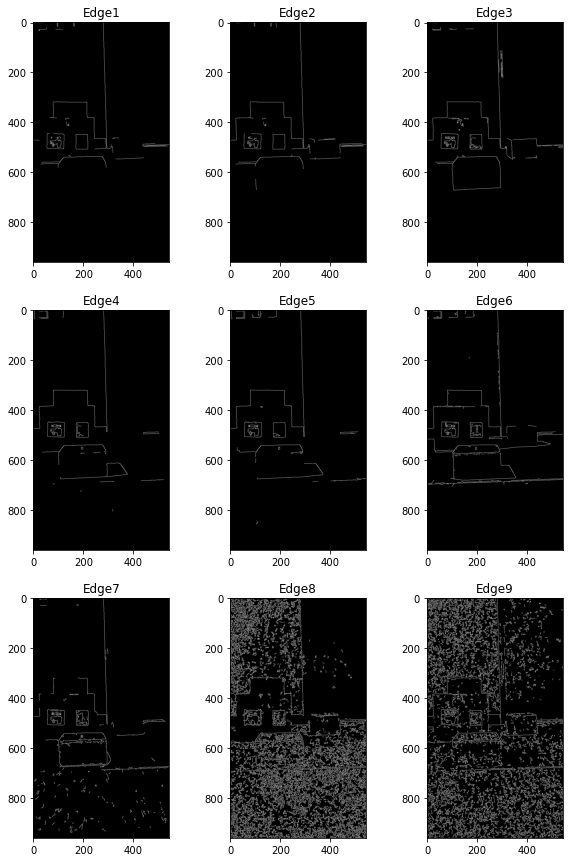

In [37]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

In [38]:
blur = cv2.GaussianBlur(im0_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge0 = auto_canny(stretched)
blur = cv2.GaussianBlur(im1_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge1 = auto_canny(stretched)
blur = cv2.GaussianBlur(im2_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge2 = auto_canny(stretched)
blur = cv2.GaussianBlur(im3_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge3 = auto_canny(stretched)
blur = cv2.GaussianBlur(im4_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge4 = auto_canny(stretched)
blur = cv2.GaussianBlur(im5_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge5 = auto_canny(stretched)
blur = cv2.GaussianBlur(im6_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge6 = auto_canny(stretched)
blur = cv2.GaussianBlur(im7_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge7 = auto_canny(stretched)
blur = cv2.GaussianBlur(im8_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge8 = auto_canny(stretched)
blur = cv2.GaussianBlur(im9_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge9 = auto_canny(stretched)

print("Auto canny with Contrast stretching + Gaussian F")
print_metrics()

Original intensity std 31.97 --> Stretched intensity std 38.83
Threshold (lower) 104 (upper) 207
Original intensity std 35.54 --> Stretched intensity std 47.69
Threshold (lower) 115 (upper) 230
Original intensity std 29.58 --> Stretched intensity std 36.25
Threshold (lower) 96 (upper) 191
Original intensity std 26.58 --> Stretched intensity std 33.90
Threshold (lower) 63 (upper) 126
Original intensity std 18.88 --> Stretched intensity std 55.41
Threshold (lower) 78 (upper) 155
Original intensity std 15.86 --> Stretched intensity std 53.91
Threshold (lower) 75 (upper) 148
Original intensity std 26.61 --> Stretched intensity std 53.21
Threshold (lower) 42 (upper) 85
Original intensity std 14.78 --> Stretched intensity std 42.37
Threshold (lower) 42 (upper) 83
Original intensity std 4.23 --> Stretched intensity std 18.93
Threshold (lower) 20 (upper) 41
Original intensity std 9.13 --> Stretched intensity std 27.39
Threshold (lower) 22 (upper) 43
Auto canny with Contrast stretching + Gaussi

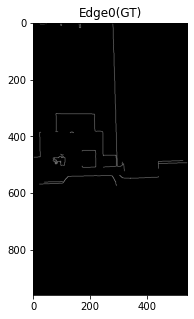

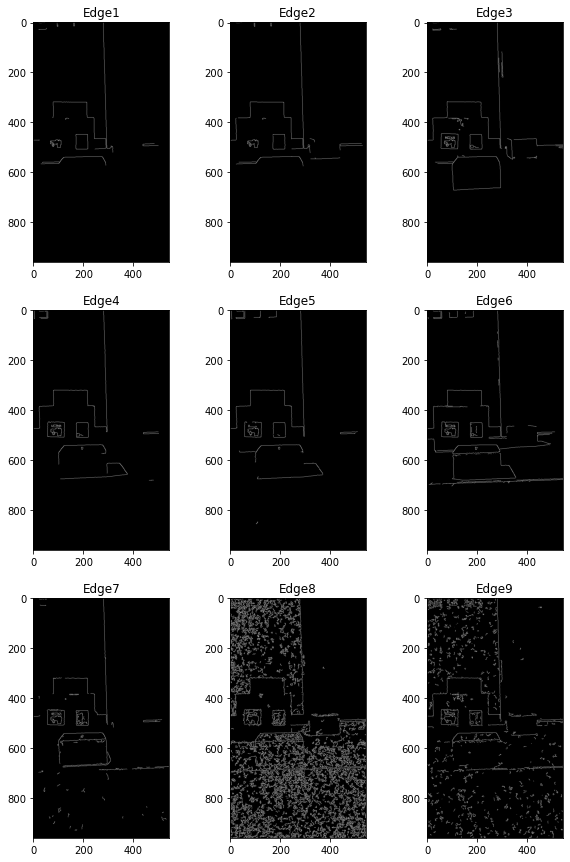

In [39]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### contrast stretching + Non-local F 

In [40]:
blur = cv2.fastNlMeansDenoising(im0_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge0 = auto_canny(stretched)
blur = cv2.fastNlMeansDenoising(im1_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge1 = auto_canny(stretched)
blur = cv2.fastNlMeansDenoising(im2_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge2 = auto_canny(stretched)
blur = cv2.fastNlMeansDenoising(im3_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge3 = auto_canny(stretched)
blur = cv2.fastNlMeansDenoising(im4_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge4 = auto_canny(stretched)
blur = cv2.fastNlMeansDenoising(im5_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge5 = auto_canny(stretched)
blur = cv2.fastNlMeansDenoising(im6_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge6 = auto_canny(stretched)
blur = cv2.fastNlMeansDenoising(im7_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge7 = auto_canny(stretched)
blur = cv2.fastNlMeansDenoising(im8_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge8 = auto_canny(stretched)
blur = cv2.fastNlMeansDenoising(im9_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge9 = auto_canny(stretched)

print("Auto Canny with Non-local mean F")
print("#### h=5, templatewindow=5, searchwindow=7")
print_metrics()

Original intensity std 32.19 --> Stretched intensity std 35.85
Threshold (lower) 102 (upper) 203
Original intensity std 35.73 --> Stretched intensity std 42.37
Threshold (lower) 113 (upper) 224
Original intensity std 29.77 --> Stretched intensity std 33.74
Threshold (lower) 95 (upper) 190
Original intensity std 26.77 --> Stretched intensity std 31.31
Threshold (lower) 62 (upper) 125
Original intensity std 18.90 --> Stretched intensity std 55.43
Threshold (lower) 80 (upper) 159
Original intensity std 15.86 --> Stretched intensity std 43.98
Threshold (lower) 60 (upper) 121
Original intensity std 26.68 --> Stretched intensity std 51.11
Threshold (lower) 42 (upper) 83
Original intensity std 14.77 --> Stretched intensity std 27.31
Threshold (lower) 26 (upper) 53
Original intensity std 4.21 --> Stretched intensity std 12.57
Threshold (lower) 13 (upper) 26
Original intensity std 9.12 --> Stretched intensity std 19.65
Threshold (lower) 14 (upper) 27
Auto Canny with Non-local mean F
#### h=5, t

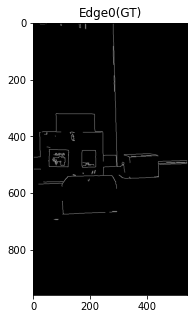

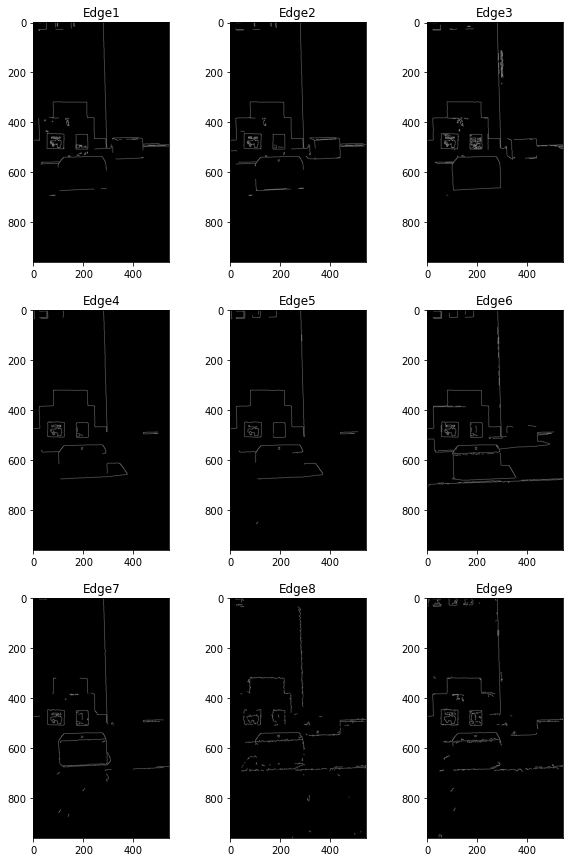

In [41]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### contrast stretching + Guided F 

In [42]:
guide = im0_gray.copy()

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im0_gray, radius=radius, eps=eps)
edge0 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im1_gray, radius=radius, eps=eps)
edge1 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im2_gray, radius=radius, eps=eps)
edge2 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im3_gray, radius=radius, eps=eps)
edge3 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im4_gray, radius=radius, eps=eps)
edge4 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im5_gray, radius=radius, eps=eps)
edge5 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im6_gray, radius=radius, eps=eps)
edge6 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im7_gray, radius=radius, eps=eps)
edge7 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im8_gray, radius=radius, eps=eps)
edge8 = auto_canny(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im9_gray, radius=radius, eps=eps)
edge9 = auto_canny(blur)

print("Auto canny with Guided Filter (lightest guide img)")
print(f"#### radius={radius}, eps={eps}")
print_metrics()

Threshold (lower) 105 (upper) 208
Threshold (lower) 106 (upper) 211
Threshold (lower) 96 (upper) 191
Threshold (lower) 71 (upper) 142
Threshold (lower) 36 (upper) 73
Threshold (lower) 32 (upper) 63
Threshold (lower) 31 (upper) 62
Threshold (lower) 24 (upper) 49
Threshold (lower) 14 (upper) 29
Threshold (lower) 17 (upper) 34
Auto canny with Guided Filter (lightest guide img)
#### radius=5, eps=0.1
Edge1 F1-score : 0.84 / Auc score : 0.88
Edge2 F1-score : 0.90 / Auc score : 0.93
Edge3 F1-score : 0.72 / Auc score : 0.83
Edge4 F1-score : 0.68 / Auc score : 0.79
Edge5 F1-score : 0.66 / Auc score : 0.77
Edge6 F1-score : 0.58 / Auc score : 0.82
Edge7 F1-score : 0.60 / Auc score : 0.76
Edge8 F1-score : 0.38 / Auc score : 0.63
Edge9 F1-score : 0.68 / Auc score : 0.78


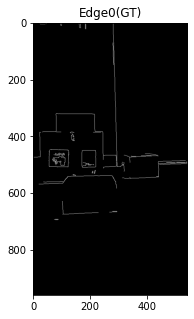

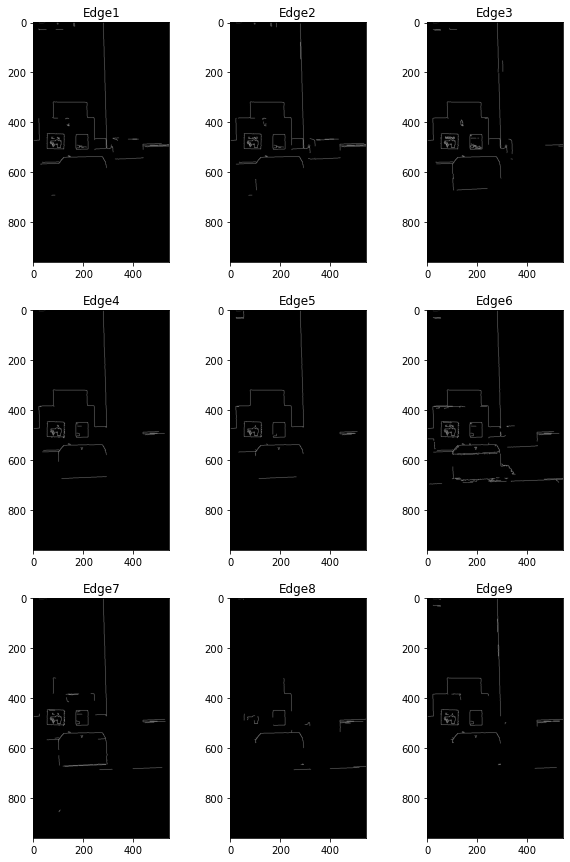

In [43]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

## 3. Auto Canny with Otsu 

In [44]:
edge0 = auto_canny_otsu(im0_gray)
edge1 = auto_canny_otsu(im1_gray)
edge2 = auto_canny_otsu(im2_gray)
edge3 = auto_canny_otsu(im3_gray)
edge4 = auto_canny_otsu(im4_gray)
edge5 = auto_canny_otsu(im5_gray)
edge6 = auto_canny_otsu(im6_gray)
edge7 = auto_canny_otsu(im7_gray)
edge8 = auto_canny_otsu(im8_gray)
edge9 = auto_canny_otsu(im9_gray)

print("Auto canny with Otsu")
print_metrics()

67.0 134.0
65.5 131.0
61.5 123.0
61.0 122.0
21.0 42.0
18.5 37.0
30.0 60.0
18.0 36.0
10.0 20.0
16.5 33.0
Auto canny with Otsu
Edge1 F1-score : 0.52 / Auc score : 0.76
Edge2 F1-score : 0.60 / Auc score : 0.79
Edge3 F1-score : 0.38 / Auc score : 0.67
Edge4 F1-score : 0.12 / Auc score : 0.57
Edge5 F1-score : 0.12 / Auc score : 0.57
Edge6 F1-score : 0.14 / Auc score : 0.56
Edge7 F1-score : 0.13 / Auc score : 0.57
Edge8 F1-score : 0.12 / Auc score : 0.57
Edge9 F1-score : 0.28 / Auc score : 0.61


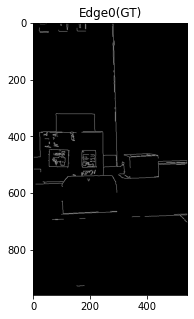

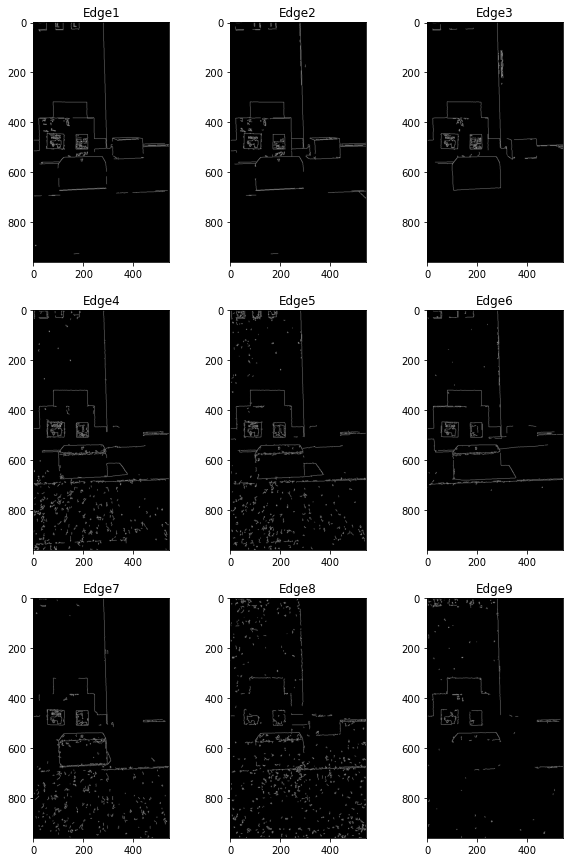

In [45]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### Median F

In [46]:
blur = cv2.medianBlur(im0_gray, 3)
edge0 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im1_gray, 3)
edge1 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im2_gray, 3)
edge2 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im3_gray, 3)
edge3 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im4_gray, 3)
edge4 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im5_gray, 3)
edge5 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im6_gray, 3)
edge6 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im7_gray, 3)
edge7 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im8_gray, 3)
edge8 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im9_gray, 3)
edge9 = auto_canny_otsu(blur)

print("Auto canny & Median F 3x3")
print_metrics()

67.0 134.0
65.5 131.0
61.5 123.0
61.0 122.0
21.0 42.0
18.5 37.0
30.0 60.0
18.0 36.0
10.0 20.0
16.5 33.0
Auto canny & Median F 3x3
Edge1 F1-score : 0.55 / Auc score : 0.76
Edge2 F1-score : 0.59 / Auc score : 0.78
Edge3 F1-score : 0.40 / Auc score : 0.68
Edge4 F1-score : 0.16 / Auc score : 0.59
Edge5 F1-score : 0.16 / Auc score : 0.58
Edge6 F1-score : 0.14 / Auc score : 0.57
Edge7 F1-score : 0.17 / Auc score : 0.58
Edge8 F1-score : 0.20 / Auc score : 0.59
Edge9 F1-score : 0.34 / Auc score : 0.63


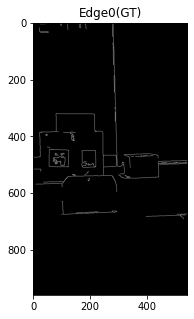

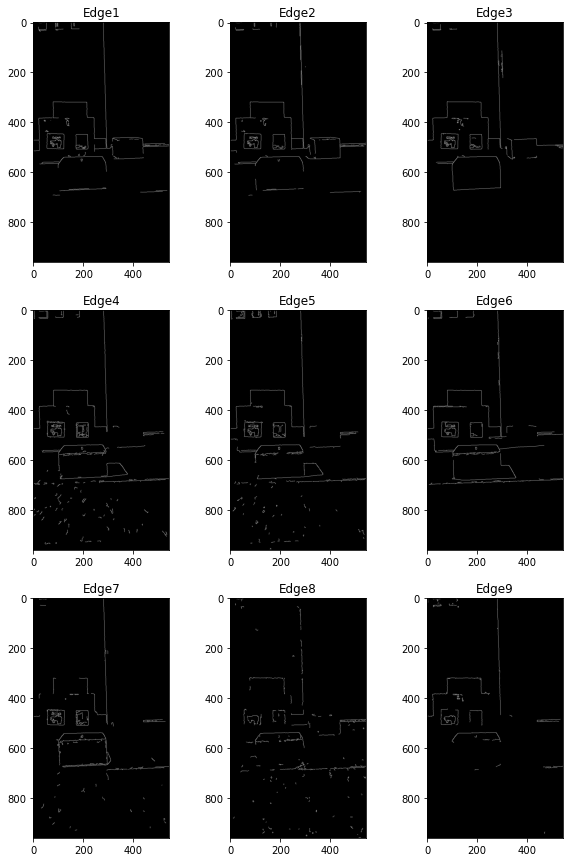

In [47]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

In [48]:
blur = cv2.medianBlur(im0_gray, 5)
edge0 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im1_gray, 5)
edge1 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im2_gray, 5)
edge2 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im3_gray, 5)
edge3 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im4_gray, 5)
edge4 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im5_gray, 5)
edge5 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im6_gray, 5)
edge6 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im7_gray, 5)
edge7 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im8_gray, 5)
edge8 = auto_canny_otsu(blur)
blur = cv2.medianBlur(im9_gray, 5)
edge9 = auto_canny_otsu(blur)

print("Auto canny & Median F 5x5")
print_metrics()

67.0 134.0
65.5 131.0
61.5 123.0
61.0 122.0
21.0 42.0
18.5 37.0
30.0 60.0
18.0 36.0
10.0 20.0
16.5 33.0
Auto canny & Median F 5x5
Edge1 F1-score : 0.56 / Auc score : 0.77
Edge2 F1-score : 0.61 / Auc score : 0.80
Edge3 F1-score : 0.43 / Auc score : 0.70
Edge4 F1-score : 0.15 / Auc score : 0.58
Edge5 F1-score : 0.14 / Auc score : 0.57
Edge6 F1-score : 0.13 / Auc score : 0.56
Edge7 F1-score : 0.15 / Auc score : 0.57
Edge8 F1-score : 0.21 / Auc score : 0.58
Edge9 F1-score : 0.40 / Auc score : 0.66


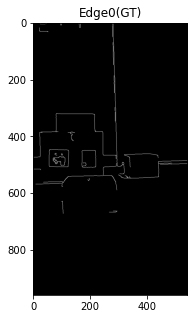

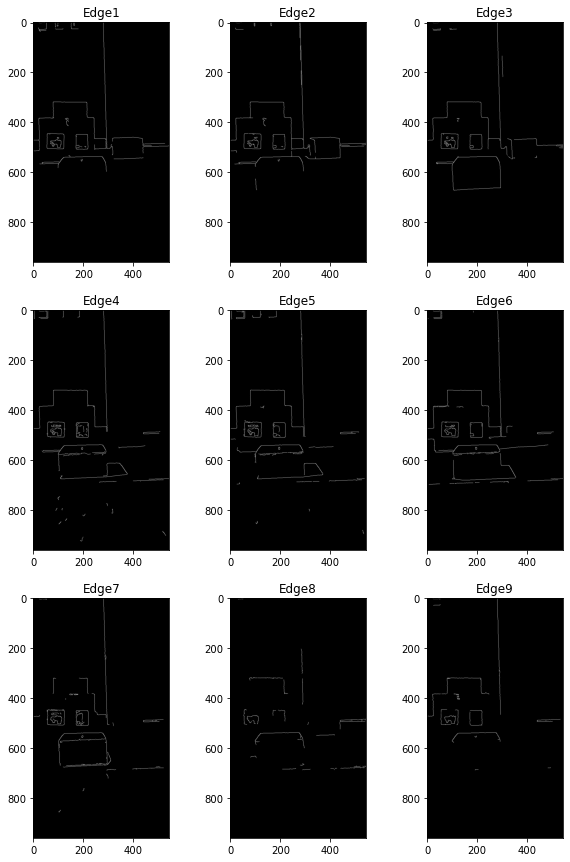

In [49]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

In [50]:
blur = cv2.GaussianBlur(im0_gray, (3, 3), 0) 
edge0 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im1_gray, (3, 3), 0) 
edge1 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im2_gray, (3, 3), 0) 
edge2 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im3_gray, (3, 3), 0) 
edge3 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im4_gray, (3, 3), 0) 
edge4 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im5_gray, (3, 3), 0) 
edge5 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im6_gray, (3, 3), 0) 
edge6 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im7_gray, (3, 3), 0) 
edge7 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im8_gray, (3, 3), 0) 
edge8 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im9_gray, (3, 3), 0) 
edge9 = auto_canny_otsu(blur)

print("Auto canny & Gauss F 3x3")
print_metrics()

67.0 134.0
65.5 131.0
61.5 123.0
61.0 122.0
21.0 42.0
18.5 37.0
30.0 60.0
18.0 36.0
10.0 20.0
16.5 33.0
Auto canny & Gauss F 3x3
Edge1 F1-score : 0.59 / Auc score : 0.79
Edge2 F1-score : 0.64 / Auc score : 0.82
Edge3 F1-score : 0.43 / Auc score : 0.70
Edge4 F1-score : 0.15 / Auc score : 0.58
Edge5 F1-score : 0.14 / Auc score : 0.57
Edge6 F1-score : 0.11 / Auc score : 0.56
Edge7 F1-score : 0.15 / Auc score : 0.57
Edge8 F1-score : 0.18 / Auc score : 0.57
Edge9 F1-score : 0.36 / Auc score : 0.63


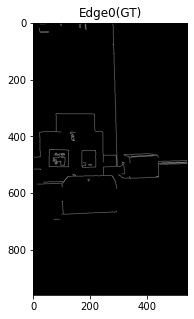

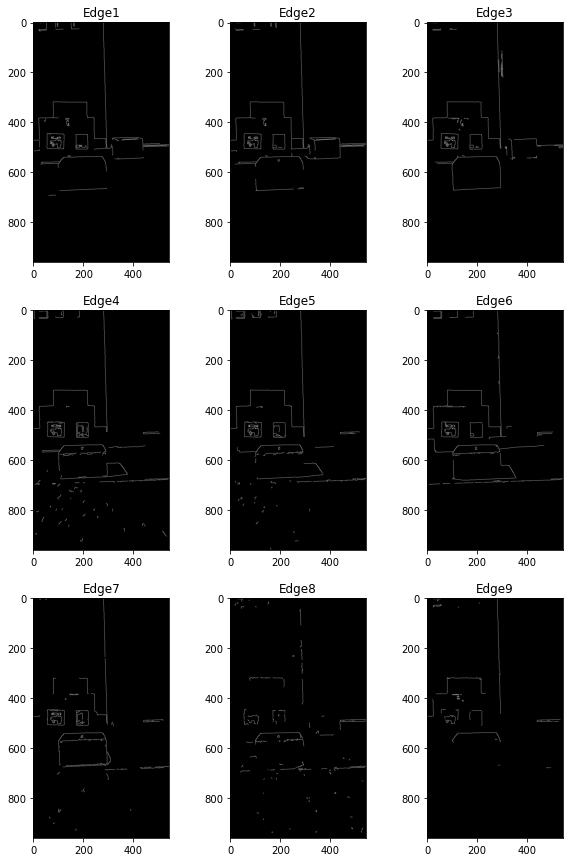

In [51]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

In [52]:
blur = cv2.GaussianBlur(im0_gray, (5, 5), 0) 
edge0 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im1_gray, (5, 5), 0) 
edge1 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im2_gray, (5, 5), 0) 
edge2 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im3_gray, (5, 5), 0) 
edge3 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im4_gray, (5, 5), 0) 
edge4 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im5_gray, (5, 5), 0) 
edge5 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im6_gray, (5, 5), 0) 
edge6 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im7_gray, (5, 5), 0) 
edge7 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im8_gray, (5, 5), 0) 
edge8 = auto_canny_otsu(blur)
blur = cv2.GaussianBlur(im9_gray, (5, 5), 0) 
edge9 = auto_canny_otsu(blur)

print("Auto canny & Gauss F 5x5")
print_metrics()

67.0 134.0
65.5 131.0
61.5 123.0
61.0 122.0
21.0 42.0
18.5 37.0
30.0 60.0
18.0 36.0
10.0 20.0
16.5 33.0
Auto canny & Gauss F 5x5
Edge1 F1-score : 0.59 / Auc score : 0.79
Edge2 F1-score : 0.63 / Auc score : 0.82
Edge3 F1-score : 0.44 / Auc score : 0.72
Edge4 F1-score : 0.14 / Auc score : 0.57
Edge5 F1-score : 0.13 / Auc score : 0.57
Edge6 F1-score : 0.10 / Auc score : 0.55
Edge7 F1-score : 0.14 / Auc score : 0.57
Edge8 F1-score : 0.20 / Auc score : 0.57
Edge9 F1-score : 0.36 / Auc score : 0.64


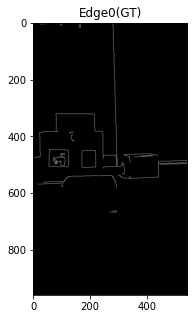

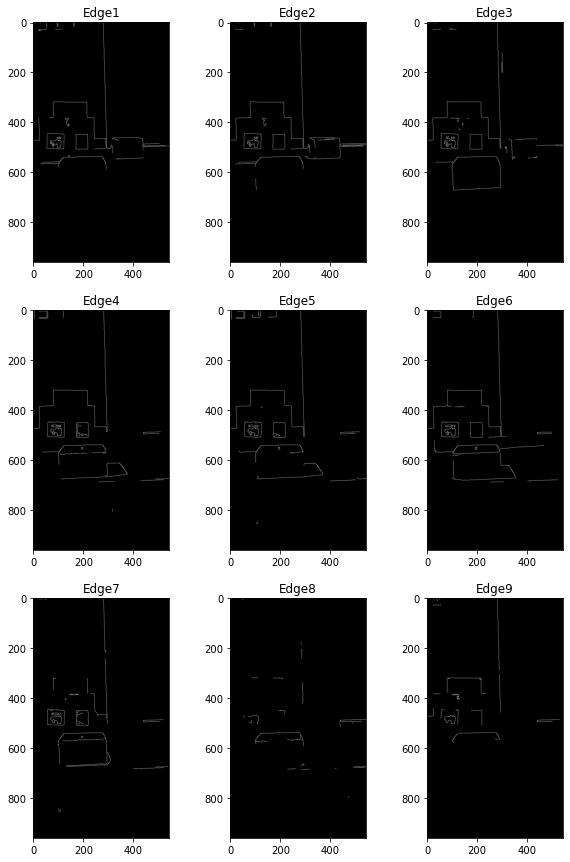

In [53]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### Non-local F 

In [54]:
blur = cv2.fastNlMeansDenoising(im0_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge0 = auto_canny_otsu(blur)
blur = cv2.fastNlMeansDenoising(im1_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge1 = auto_canny_otsu(blur)
blur = cv2.fastNlMeansDenoising(im2_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge2 = auto_canny_otsu(blur)
blur = cv2.fastNlMeansDenoising(im3_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge3 = auto_canny_otsu(blur)
blur = cv2.fastNlMeansDenoising(im4_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge4 = auto_canny_otsu(blur)
blur = cv2.fastNlMeansDenoising(im5_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge5 = auto_canny_otsu(blur)
blur = cv2.fastNlMeansDenoising(im6_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge6 = auto_canny_otsu(blur)
blur = cv2.fastNlMeansDenoising(im7_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge7 = auto_canny_otsu(blur)
blur = cv2.fastNlMeansDenoising(im8_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge8 = auto_canny_otsu(blur)
blur = cv2.fastNlMeansDenoising(im9_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge9 = auto_canny_otsu(blur)

print("Auto Canny with Non-local mean F")
print("#### h=5, templatewindow=5, searchwindow=7")
print_metrics()

67.0 134.0
65.5 131.0
61.5 123.0
61.0 122.0
21.0 42.0
18.5 37.0
30.0 60.0
18.0 36.0
10.0 20.0
16.5 33.0
Auto Canny with Non-local mean F
#### h=5, templatewindow=5, searchwindow=7
Edge1 F1-score : 0.54 / Auc score : 0.77
Edge2 F1-score : 0.61 / Auc score : 0.79
Edge3 F1-score : 0.40 / Auc score : 0.68
Edge4 F1-score : 0.15 / Auc score : 0.56
Edge5 F1-score : 0.14 / Auc score : 0.55
Edge6 F1-score : 0.12 / Auc score : 0.55
Edge7 F1-score : 0.13 / Auc score : 0.55
Edge8 F1-score : 0.09 / Auc score : 0.52
Edge9 F1-score : 0.26 / Auc score : 0.58


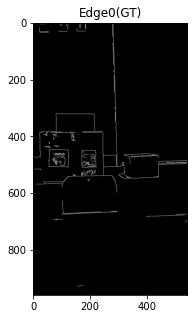

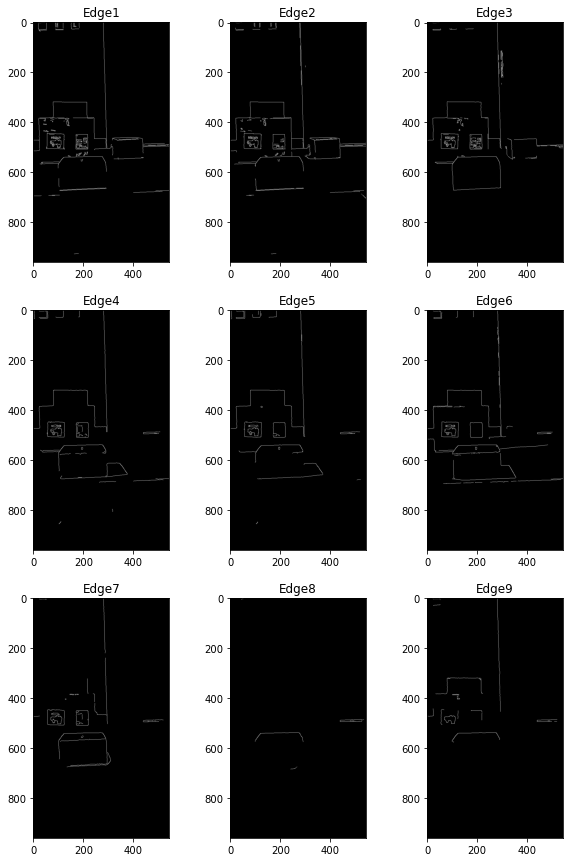

In [55]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### guided F

In [56]:
guide = im0_gray.copy()

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im0_gray, radius=radius, eps=eps)
edge0 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im1_gray, radius=radius, eps=eps)
edge1 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im2_gray, radius=radius, eps=eps)
edge2 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im3_gray, radius=radius, eps=eps)
edge3 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im4_gray, radius=radius, eps=eps)
edge4 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im5_gray, radius=radius, eps=eps)
edge5 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im6_gray, radius=radius, eps=eps)
edge6 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im7_gray, radius=radius, eps=eps)
edge7 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im8_gray, radius=radius, eps=eps)
edge8 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im9_gray, radius=radius, eps=eps)
edge9 = auto_canny_otsu(blur)

print("Auto canny with Guided Filter (lightest guide img)")
print(f"#### radius={radius}, eps={eps}")
print_metrics()

67.0 134.0
65.5 131.0
61.5 123.0
61.0 122.0
21.0 42.0
18.5 37.0
30.0 60.0
18.0 36.0
10.0 20.0
16.5 33.0
Auto canny with Guided Filter (lightest guide img)
#### radius=5, eps=0.1
Edge1 F1-score : 0.86 / Auc score : 0.90
Edge2 F1-score : 0.91 / Auc score : 0.93
Edge3 F1-score : 0.66 / Auc score : 0.76
Edge4 F1-score : 0.64 / Auc score : 0.78
Edge5 F1-score : 0.64 / Auc score : 0.78
Edge6 F1-score : 0.57 / Auc score : 0.75
Edge7 F1-score : 0.60 / Auc score : 0.76
Edge8 F1-score : 0.51 / Auc score : 0.68
Edge9 F1-score : 0.57 / Auc score : 0.71


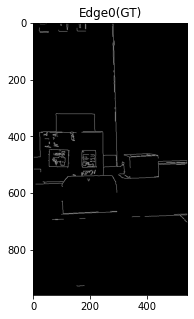

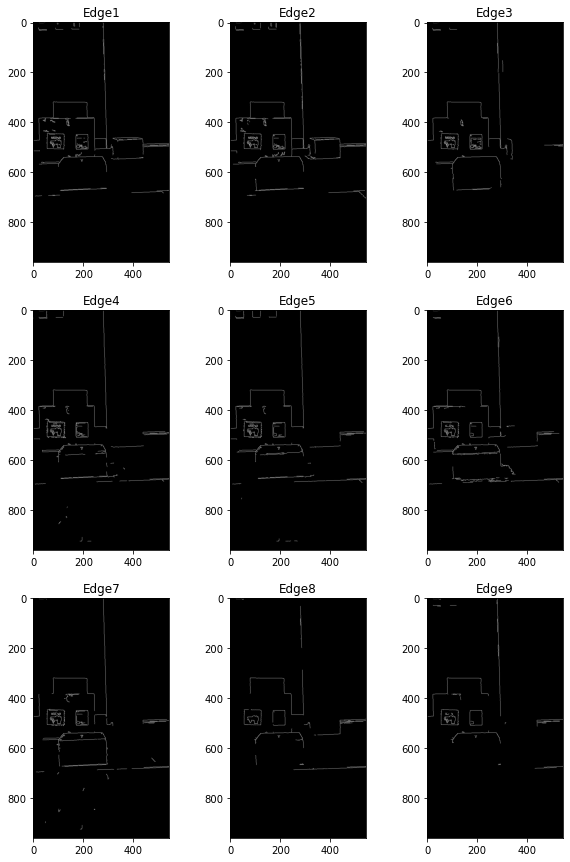

In [57]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### Contrast Stretching 

In [58]:
stretched = contrast_stretching(im0_gray)
edge0 = auto_canny_otsu(stretched)
stretched = contrast_stretching(im1_gray)
edge1 = auto_canny_otsu(stretched)
stretched = contrast_stretching(im2_gray)
edge2 = auto_canny_otsu(stretched)
stretched = contrast_stretching(im3_gray)
edge3 = auto_canny_otsu(stretched)
stretched = contrast_stretching(im4_gray)
edge4 = auto_canny_otsu(stretched)
stretched = contrast_stretching(im5_gray)
edge5 = auto_canny_otsu(stretched)
stretched = contrast_stretching(im6_gray)
edge6 = auto_canny_otsu(stretched)
stretched = contrast_stretching(im7_gray)
edge7 = auto_canny_otsu(stretched)
stretched = contrast_stretching(im8_gray)
edge8 = auto_canny_otsu(stretched)
stretched = contrast_stretching(im9_gray)
edge9 = auto_canny_otsu(stretched)

print("Auto canny with Contrast stretching")
print_metrics()

Original intensity std 32.23 --> Stretched intensity std 35.41
65.0 130.0
Original intensity std 35.78 --> Stretched intensity std 42.04
67.5 135.0
Original intensity std 29.81 --> Stretched intensity std 33.63
59.5 119.0
Original intensity std 26.80 --> Stretched intensity std 30.93
55.5 111.0
Original intensity std 18.98 --> Stretched intensity std 50.46
42.5 85.0
Original intensity std 15.94 --> Stretched intensity std 43.28
33.5 67.0
Original intensity std 26.74 --> Stretched intensity std 49.74
45.5 91.0
Original intensity std 14.85 --> Stretched intensity std 27.04
21.5 43.0
Original intensity std 4.30 --> Stretched intensity std 12.17
11.0 22.0
Original intensity std 9.20 --> Stretched intensity std 19.42
21.0 42.0
Auto canny with Contrast stretching
Edge1 F1-score : 0.53 / Auc score : 0.76
Edge2 F1-score : 0.59 / Auc score : 0.79
Edge3 F1-score : 0.38 / Auc score : 0.67
Edge4 F1-score : 0.08 / Auc score : 0.57
Edge5 F1-score : 0.05 / Auc score : 0.56
Edge6 F1-score : 0.13 / Auc

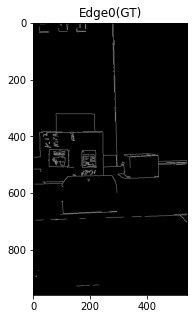

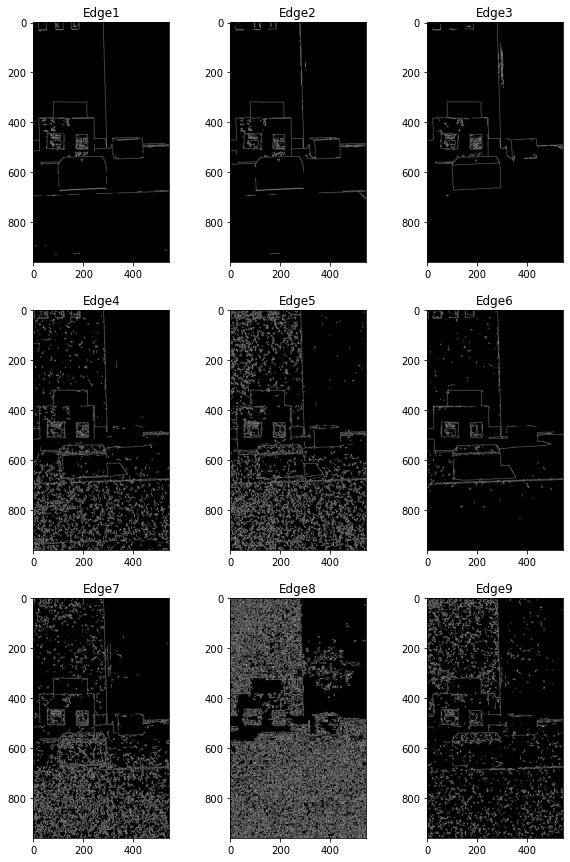

In [59]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### Contrast stretching + Median F

In [60]:
blur = cv2.medianBlur(im0_gray, 3)
stretched = contrast_stretching(blur)
edge0 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im1_gray, 3)
stretched = contrast_stretching(blur)
edge1 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im2_gray, 3)
stretched = contrast_stretching(blur)
edge2 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im3_gray, 3)
stretched = contrast_stretching(blur)
edge3 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im4_gray, 3)
stretched = contrast_stretching(blur)
edge4 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im5_gray, 3)
stretched = contrast_stretching(blur)
edge5 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im6_gray, 3)
stretched = contrast_stretching(blur)
edge6 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im7_gray, 3)
stretched = contrast_stretching(blur)
edge7 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im8_gray, 3)
stretched = contrast_stretching(blur)
edge8 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im9_gray, 3)
stretched = contrast_stretching(blur)
edge9 = auto_canny_otsu(stretched)

print("Auto canny with Contrast stretching + Median F")
print_metrics()

Original intensity std 32.12 --> Stretched intensity std 38.27
64.5 129.0
Original intensity std 35.69 --> Stretched intensity std 45.97
66.0 132.0
Original intensity std 29.71 --> Stretched intensity std 35.41
58.0 116.0
Original intensity std 26.72 --> Stretched intensity std 32.60
56.0 112.0
Original intensity std 18.94 --> Stretched intensity std 55.56
39.5 79.0
Original intensity std 15.90 --> Stretched intensity std 51.33
35.5 71.0
Original intensity std 26.70 --> Stretched intensity std 53.39
44.5 89.0
Original intensity std 14.81 --> Stretched intensity std 34.06
26.0 52.0
Original intensity std 4.26 --> Stretched intensity std 17.78
14.5 29.0
Original intensity std 9.16 --> Stretched intensity std 23.84
24.5 49.0
Auto canny with Contrast stretching + Median F
Edge1 F1-score : 0.52 / Auc score : 0.76
Edge2 F1-score : 0.59 / Auc score : 0.79
Edge3 F1-score : 0.37 / Auc score : 0.67
Edge4 F1-score : 0.09 / Auc score : 0.59
Edge5 F1-score : 0.07 / Auc score : 0.59
Edge6 F1-score :

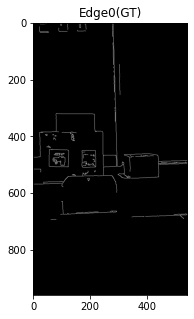

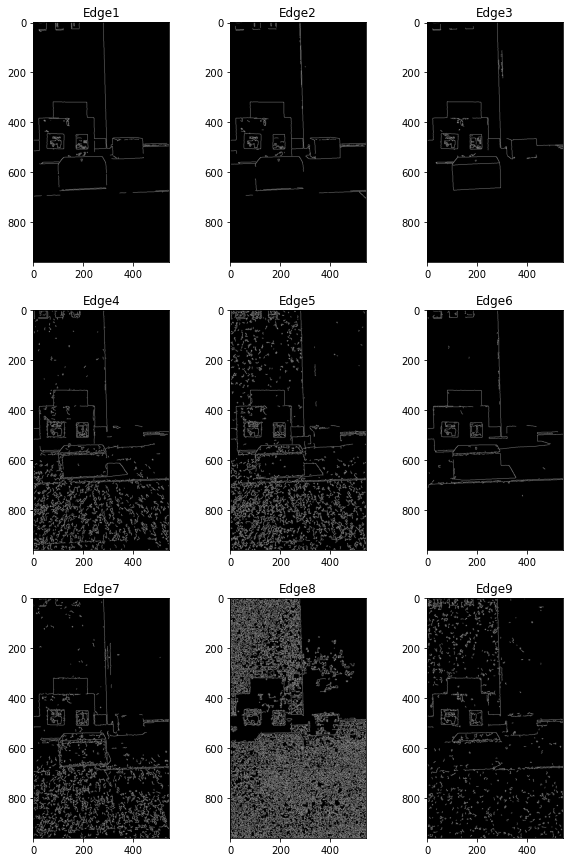

In [61]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

In [62]:
blur = cv2.medianBlur(im0_gray, 5)
stretched = contrast_stretching(blur)
edge0 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im1_gray, 5)
stretched = contrast_stretching(blur)
edge1 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im2_gray, 5)
stretched = contrast_stretching(blur)
edge2 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im3_gray, 5)
stretched = contrast_stretching(blur)
edge3 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im4_gray, 5)
stretched = contrast_stretching(blur)
edge4 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im5_gray, 5)
stretched = contrast_stretching(blur)
edge5 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im6_gray, 5)
stretched = contrast_stretching(blur)
edge6 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im7_gray, 5)
stretched = contrast_stretching(blur)
edge7 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im8_gray, 5)
stretched = contrast_stretching(blur)
edge8 = auto_canny_otsu(stretched)
blur = cv2.medianBlur(im9_gray, 5)
stretched = contrast_stretching(blur)
edge9 = auto_canny_otsu(stretched)

print("Auto canny with Contrast stretching + Median F")
print_metrics()

Original intensity std 32.04 --> Stretched intensity std 38.91
64.5 129.0
Original intensity std 35.62 --> Stretched intensity std 47.79
67.5 135.0
Original intensity std 29.64 --> Stretched intensity std 36.00
58.5 117.0
Original intensity std 26.66 --> Stretched intensity std 33.33
55.5 111.0
Original intensity std 18.90 --> Stretched intensity std 56.20
40.0 80.0
Original intensity std 15.87 --> Stretched intensity std 60.36
41.5 83.0
Original intensity std 26.65 --> Stretched intensity std 54.77
45.0 90.0
Original intensity std 14.77 --> Stretched intensity std 49.55
36.5 73.0
Original intensity std 4.22 --> Stretched intensity std 18.89
11.0 22.0
Original intensity std 9.12 --> Stretched intensity std 35.78
35.0 70.0
Auto canny with Contrast stretching + Median F
Edge1 F1-score : 0.56 / Auc score : 0.78
Edge2 F1-score : 0.61 / Auc score : 0.80
Edge3 F1-score : 0.39 / Auc score : 0.69
Edge4 F1-score : 0.11 / Auc score : 0.58
Edge5 F1-score : 0.12 / Auc score : 0.60
Edge6 F1-score :

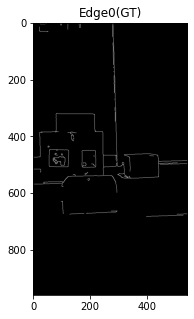

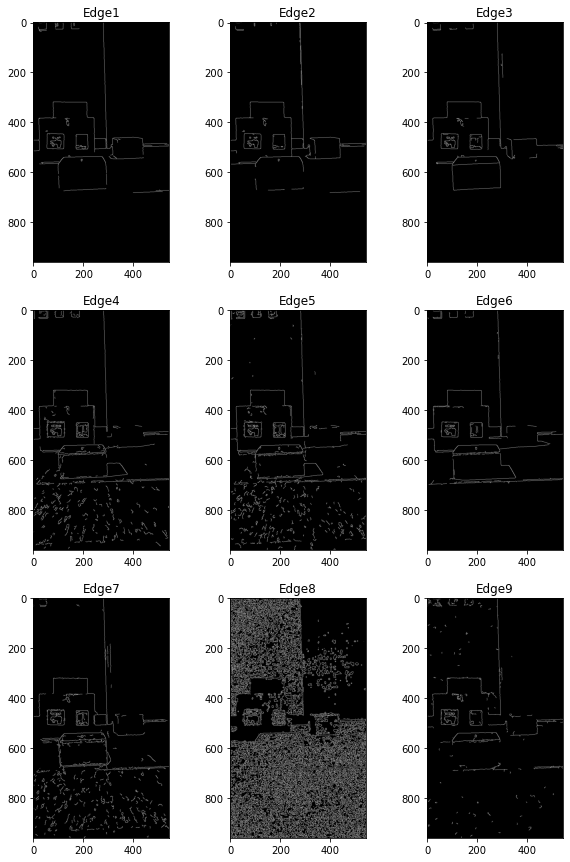

In [63]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### contrast stretching + Gaussian F 

In [64]:
blur = cv2.GaussianBlur(im0_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge0 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im1_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge1 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im2_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge2 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im3_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge3 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im4_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge4 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im5_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge5 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im6_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge6 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im7_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge7 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im8_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge8 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im9_gray, (3, 3), 0) 
stretched = contrast_stretching(blur)
edge9 = auto_canny_otsu(stretched)

print("Auto canny with Contrast stretching + Gaussian F")
print_metrics()

Original intensity std 32.06 --> Stretched intensity std 38.38
64.5 129.0
Original intensity std 35.62 --> Stretched intensity std 45.42
66.0 132.0
Original intensity std 29.66 --> Stretched intensity std 35.34
58.0 116.0
Original intensity std 26.65 --> Stretched intensity std 32.37
56.0 112.0
Original intensity std 18.92 --> Stretched intensity std 54.18
40.0 80.0
Original intensity std 15.89 --> Stretched intensity std 49.41
34.0 68.0
Original intensity std 26.66 --> Stretched intensity std 52.78
46.0 92.0
Original intensity std 14.81 --> Stretched intensity std 36.72
28.0 56.0
Original intensity std 4.26 --> Stretched intensity std 16.02
11.0 22.0
Original intensity std 9.16 --> Stretched intensity std 24.07
23.5 47.0
Auto canny with Contrast stretching + Gaussian F
Edge1 F1-score : 0.57 / Auc score : 0.78
Edge2 F1-score : 0.62 / Auc score : 0.80
Edge3 F1-score : 0.41 / Auc score : 0.69
Edge4 F1-score : 0.10 / Auc score : 0.59
Edge5 F1-score : 0.07 / Auc score : 0.58
Edge6 F1-score

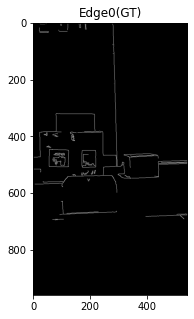

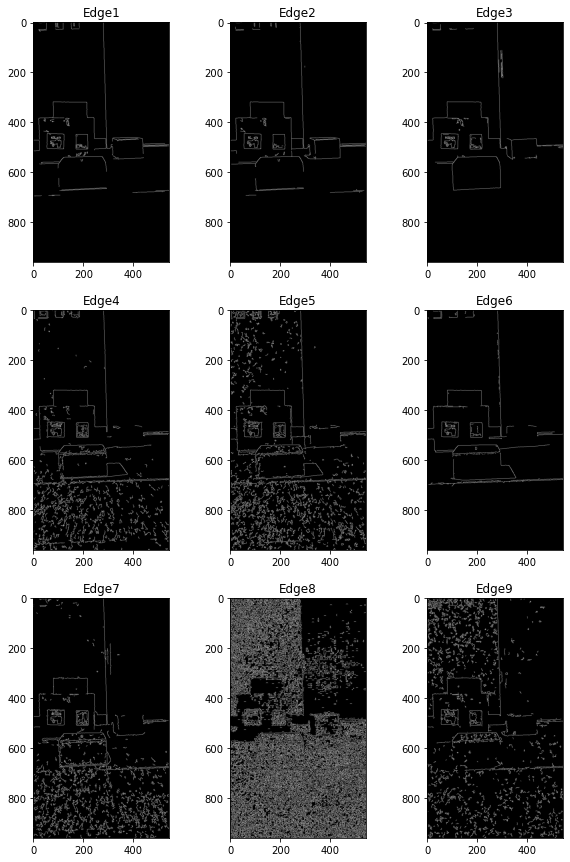

In [65]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

In [66]:
blur = cv2.GaussianBlur(im0_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge0 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im1_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge1 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im2_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge2 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im3_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge3 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im4_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge4 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im5_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge5 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im6_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge6 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im7_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge7 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im8_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge8 = auto_canny_otsu(stretched)
blur = cv2.GaussianBlur(im9_gray, (5, 5), 0) 
stretched = contrast_stretching(blur)
edge9 = auto_canny_otsu(stretched)

print("Auto canny with Contrast stretching + Gaussian F")
print_metrics()

Original intensity std 31.97 --> Stretched intensity std 38.83
64.5 129.0
Original intensity std 35.54 --> Stretched intensity std 47.69
67.5 135.0
Original intensity std 29.58 --> Stretched intensity std 36.25
59.0 118.0
Original intensity std 26.58 --> Stretched intensity std 33.90
57.0 114.0
Original intensity std 18.88 --> Stretched intensity std 55.41
39.5 79.0
Original intensity std 15.86 --> Stretched intensity std 53.91
37.0 74.0
Original intensity std 26.61 --> Stretched intensity std 53.21
45.0 90.0
Original intensity std 14.78 --> Stretched intensity std 42.37
28.5 57.0
Original intensity std 4.23 --> Stretched intensity std 18.93
11.0 22.0
Original intensity std 9.13 --> Stretched intensity std 27.39
27.0 54.0
Auto canny with Contrast stretching + Gaussian F
Edge1 F1-score : 0.59 / Auc score : 0.80
Edge2 F1-score : 0.66 / Auc score : 0.83
Edge3 F1-score : 0.43 / Auc score : 0.71
Edge4 F1-score : 0.11 / Auc score : 0.59
Edge5 F1-score : 0.11 / Auc score : 0.59
Edge6 F1-score

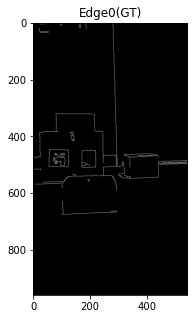

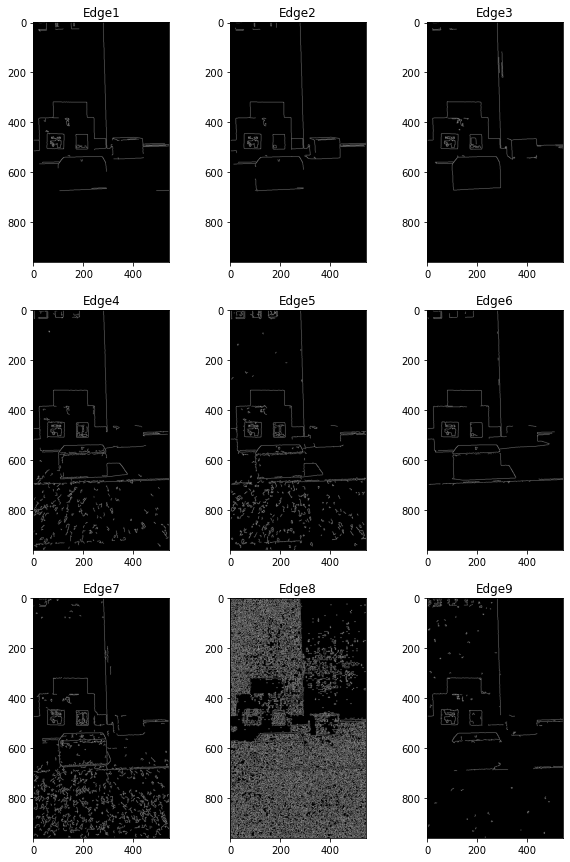

In [67]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### contrast stretching + Non-local F 

In [68]:
blur = cv2.fastNlMeansDenoising(im0_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge0 = auto_canny_otsu(stretched)
blur = cv2.fastNlMeansDenoising(im1_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge1 = auto_canny_otsu(stretched)
blur = cv2.fastNlMeansDenoising(im2_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge2 = auto_canny_otsu(stretched)
blur = cv2.fastNlMeansDenoising(im3_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge3 = auto_canny_otsu(stretched)
blur = cv2.fastNlMeansDenoising(im4_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge4 = auto_canny_otsu(stretched)
blur = cv2.fastNlMeansDenoising(im5_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge5 = auto_canny_otsu(stretched)
blur = cv2.fastNlMeansDenoising(im6_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge6 = auto_canny_otsu(stretched)
blur = cv2.fastNlMeansDenoising(im7_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge7 = auto_canny_otsu(stretched)
blur = cv2.fastNlMeansDenoising(im8_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge8 = auto_canny_otsu(stretched)
blur = cv2.fastNlMeansDenoising(im9_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
stretched = contrast_stretching(blur)
edge9 = auto_canny_otsu(stretched)

print("Auto Canny with Non-local mean F")
print("#### h=5, templatewindow=5, searchwindow=7")
print_metrics()

Original intensity std 32.19 --> Stretched intensity std 35.85
64.0 128.0
Original intensity std 35.73 --> Stretched intensity std 42.37
68.0 136.0
Original intensity std 29.77 --> Stretched intensity std 33.74
59.5 119.0
Original intensity std 26.77 --> Stretched intensity std 31.31
56.0 112.0
Original intensity std 18.90 --> Stretched intensity std 55.43
41.0 82.0
Original intensity std 15.86 --> Stretched intensity std 43.98
31.5 63.0
Original intensity std 26.68 --> Stretched intensity std 51.11
44.0 88.0
Original intensity std 14.77 --> Stretched intensity std 27.31
20.0 40.0
Original intensity std 4.21 --> Stretched intensity std 12.57
7.0 14.0
Original intensity std 9.12 --> Stretched intensity std 19.65
18.0 36.0
Auto Canny with Non-local mean F
#### h=5, templatewindow=5, searchwindow=7
Edge1 F1-score : 0.53 / Auc score : 0.76
Edge2 F1-score : 0.60 / Auc score : 0.79
Edge3 F1-score : 0.38 / Auc score : 0.67
Edge4 F1-score : 0.14 / Auc score : 0.56
Edge5 F1-score : 0.14 / Auc s

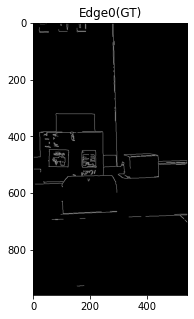

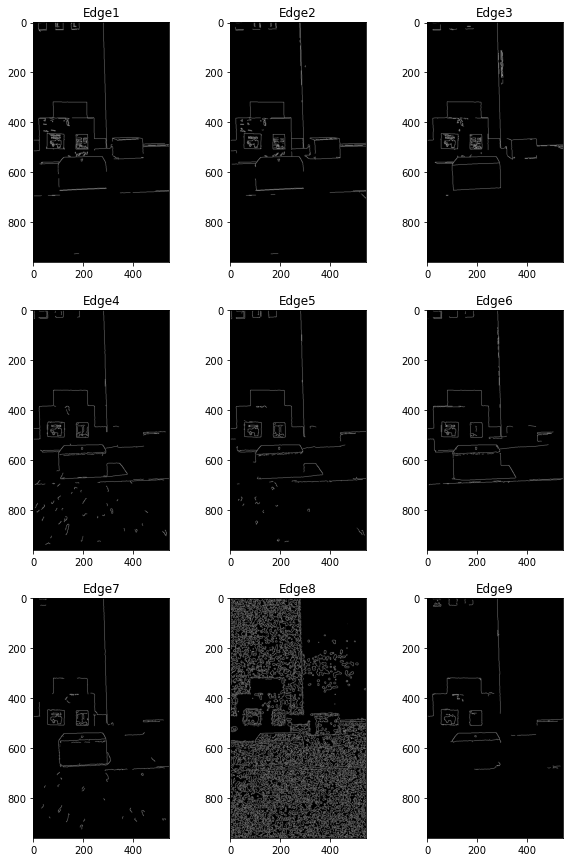

In [69]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

### contrast stretching + Guided F 

In [70]:
guide = im0_gray.copy()

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im0_gray, radius=radius, eps=eps)
edge0 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im1_gray, radius=radius, eps=eps)
edge1 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im2_gray, radius=radius, eps=eps)
edge2 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im3_gray, radius=radius, eps=eps)
edge3 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im4_gray, radius=radius, eps=eps)
edge4 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im5_gray, radius=radius, eps=eps)
edge5 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im6_gray, radius=radius, eps=eps)
edge6 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im7_gray, radius=radius, eps=eps)
edge7 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im8_gray, radius=radius, eps=eps)
edge8 = auto_canny_otsu(blur)

blur = cv2.ximgproc.guidedFilter(guide=guide, src=im9_gray, radius=radius, eps=eps)
edge9 = auto_canny_otsu(blur)

print("Auto canny with Guided Filter (lightest guide img)")
print(f"#### radius={radius}, eps={eps}")
print_metrics()

67.0 134.0
65.5 131.0
61.5 123.0
61.0 122.0
21.0 42.0
18.5 37.0
30.0 60.0
18.0 36.0
10.0 20.0
16.5 33.0
Auto canny with Guided Filter (lightest guide img)
#### radius=5, eps=0.1
Edge1 F1-score : 0.86 / Auc score : 0.90
Edge2 F1-score : 0.91 / Auc score : 0.93
Edge3 F1-score : 0.66 / Auc score : 0.76
Edge4 F1-score : 0.64 / Auc score : 0.78
Edge5 F1-score : 0.64 / Auc score : 0.78
Edge6 F1-score : 0.57 / Auc score : 0.75
Edge7 F1-score : 0.60 / Auc score : 0.76
Edge8 F1-score : 0.51 / Auc score : 0.68
Edge9 F1-score : 0.57 / Auc score : 0.71


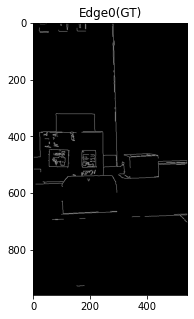

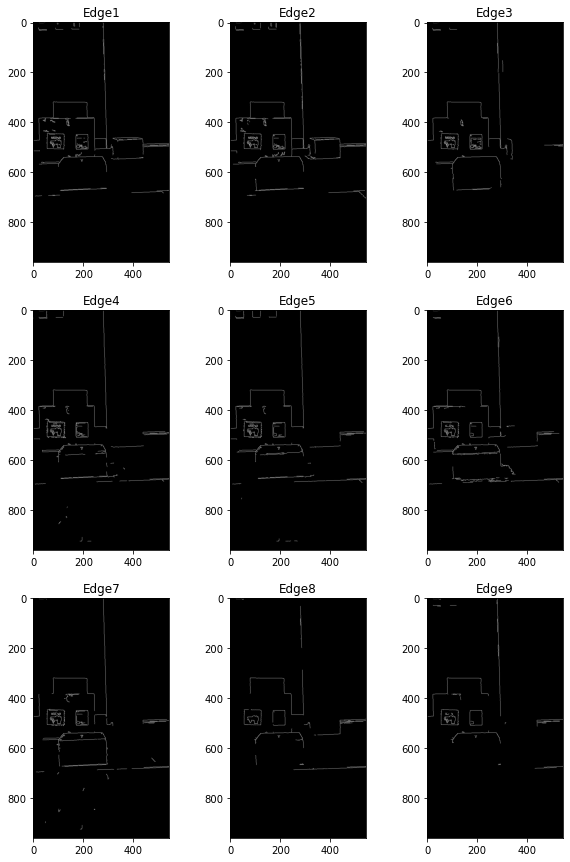

In [71]:
plt.figure(figsize=(5, 5))
plt.title("Edge0(GT)")
plt.imshow(edge0, cmap='gray')


plt.figure(figsize=(10, 15))

visualization(edge1, (3, 3, 1), title='Edge1')
visualization(edge2, (3, 3, 2), title='Edge2')
visualization(edge3, (3, 3, 3), title='Edge3')
visualization(edge4, (3, 3, 4), title='Edge4')
visualization(edge5, (3, 3, 5), title='Edge5')
visualization(edge6, (3, 3, 6), title='Edge6')
visualization(edge7, (3, 3, 7), title='Edge7')
visualization(edge8, (3, 3, 8), title='Edge8')
visualization(edge9, (3, 3, 9), title='Edge9')

## Hough Line 테스트 

edge에서 굵은 선 뽑기 

In [72]:
def calculate_angle(x1, y1, x2, y2):
    return np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi

def draw_hough_lines(edge, threshold, min_line_length, max_line_gap) :
    window = edge.copy()
    window = cv2.cvtColor(window, cv2.COLOR_GRAY2BGR)
    lines = cv2.HoughLinesP(edge, 1, np.pi/180, threshold, minLineLength=min_line_length,
                           maxLineGap=max_line_gap) 
    if lines is not None :
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)               
            if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
                cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
            else :
                cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)
        plt.title(f"{threshold},{min_line_length},{max_line_gap} / cnt : {len(lines)}")
    
    return cv2.cvtColor(window, cv2.COLOR_BGR2RGB)

67.0 134.0


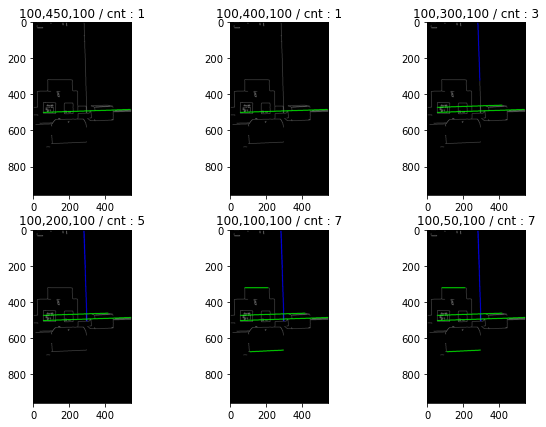

In [73]:
blur = cv2.GaussianBlur(im0_gray, (3, 3), 0) 
edge0 = auto_canny_otsu(blur)

plt.figure(figsize=(10, 7))
plt.subplot(2,3,1)
result=draw_hough_lines(edge0, 100, 450, 100)
plt.imshow(result)

plt.subplot(2,3,2)
result=draw_hough_lines(edge0, 100, 400, 100)
plt.imshow(result)


plt.subplot(2,3,3)
result=draw_hough_lines(edge0, 100, 300, 100)
plt.imshow(result)

plt.subplot(2,3,4)
result=draw_hough_lines(edge0, 100, 200, 100)
plt.imshow(result)

plt.subplot(2,3,5)
result=draw_hough_lines(edge0, 100, 100, 100)
plt.imshow(result)


plt.subplot(2,3,6)
result=draw_hough_lines(edge0, 100, 50, 100)
plt.imshow(result)

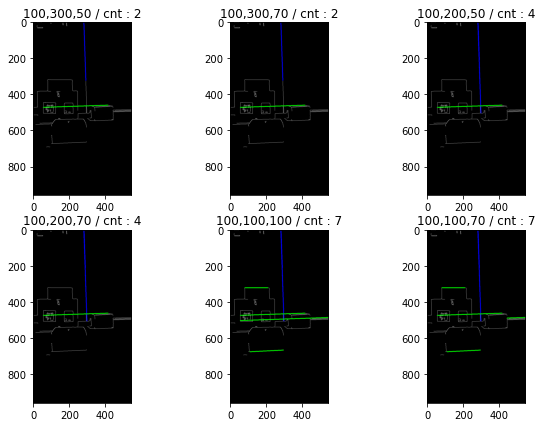

In [74]:
plt.figure(figsize=(10, 7))
plt.subplot(2,3,1)
result=draw_hough_lines(edge0, 100, 300, 50)
plt.imshow(result)

plt.subplot(2,3,2)
result=draw_hough_lines(edge0, 100, 300, 70)
plt.imshow(result)


plt.subplot(2,3,3)
result=draw_hough_lines(edge0, 100, 200, 50)
plt.imshow(result)

plt.subplot(2,3,4)
result=draw_hough_lines(edge0, 100, 200, 70)
plt.imshow(result)

plt.subplot(2,3,5)
result=draw_hough_lines(edge0, 100, 100, 100)
plt.imshow(result)


plt.subplot(2,3,6)
result=draw_hough_lines(edge0, 100, 100, 70)
plt.imshow(result)

66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0


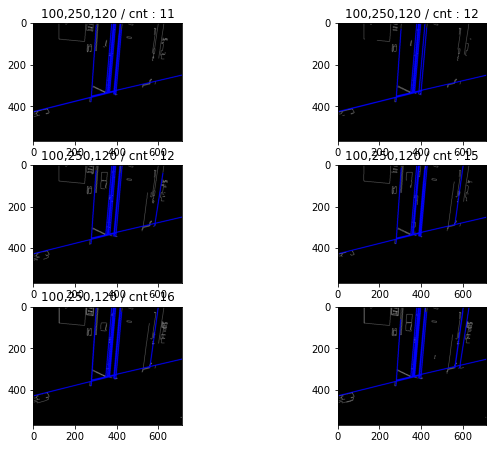

In [75]:
test=cv2.imread("./data/2doors.png")
test_gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))

blur = cv2.GaussianBlur(test_gray, (3, 3), 0) 
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 100, 250, 120)

plt.subplot(4,2,1)
plt.imshow(result)

blur = cv2.GaussianBlur(test_gray, (5, 5), 0) 
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 100, 250, 120)

plt.subplot(4,2,2)
plt.imshow(result)

blur = cv2.medianBlur(test_gray, 3) 
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 100, 250, 120)

plt.subplot(4,2,3)
plt.imshow(result)

blur = cv2.medianBlur(test_gray, 5) 
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 100, 250, 120)

plt.subplot(4,2,4)
plt.imshow(result)

blur = cv2.fastNlMeansDenoising(test_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 100, 250, 120)

plt.subplot(4,2,5)
plt.imshow(result)

blur = cv2.ximgproc.guidedFilter(guide=test_gray, src=test_gray, radius=radius, eps=eps)
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 100, 250, 120)

plt.subplot(4,2,6)
plt.imshow(result)


plt.show()

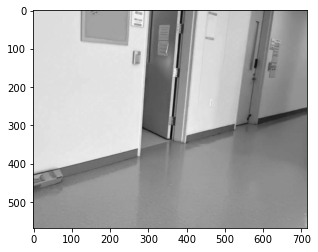

In [76]:
plt.imshow(test_gray, cmap='gray')

Original intensity std 33.67 --> Stretched intensity std 50.26
90.5 181.0


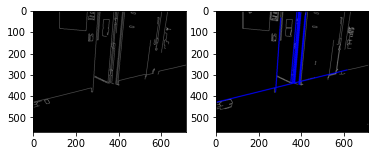

In [77]:
temp = auto_canny_otsu(contrast_stretching(cv2.medianBlur(test_gray, 5)))
result=draw_hough_lines(edge, 150, 300, 150)
plt.subplot(1,2,1)
plt.imshow(temp, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(result)

Original intensity std 33.92 --> Stretched intensity std 47.27
88.0 176.0


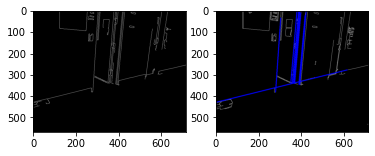

In [78]:
temp = auto_canny_otsu(cv2.medianBlur(contrast_stretching(test_gray), 5))
result=draw_hough_lines(edge, 150, 300, 150)
plt.subplot(1,2,1)
plt.imshow(temp, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(result)

66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0


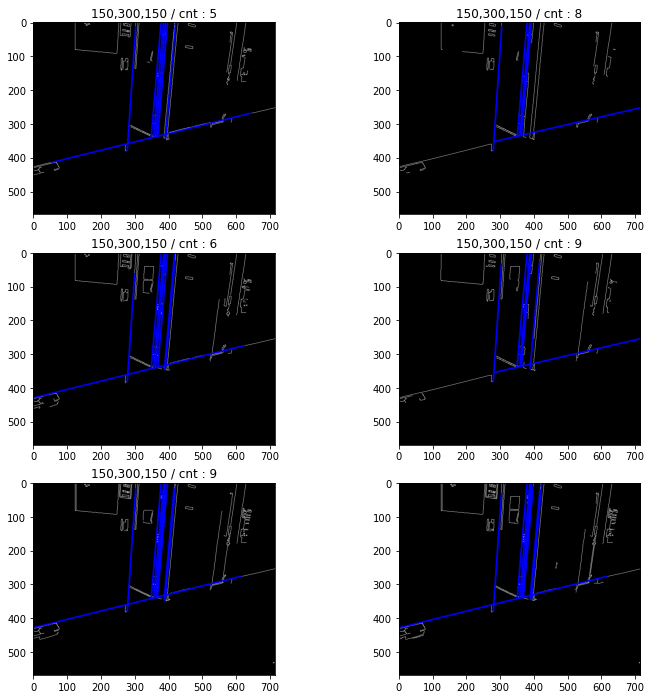

In [79]:
test=cv2.imread("./data/2doors.png")
test_gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 12))

blur = cv2.GaussianBlur(test_gray, (3, 3), 0) 
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 150, 300, 150)

plt.subplot(3,2,1)
plt.imshow(result)

blur = cv2.GaussianBlur(test_gray, (5, 5), 0) 
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 150, 300, 150)

plt.subplot(3,2,2)
plt.imshow(result)

blur = cv2.medianBlur(test_gray, 3) 
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 150, 300, 150)

plt.subplot(3,2,3)
plt.imshow(result)

blur = cv2.medianBlur(test_gray, 5) 
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 150, 300, 150)

plt.subplot(3,2,4)
plt.imshow(result)

blur = cv2.fastNlMeansDenoising(test_gray, None, h=5, templateWindowSize=5, searchWindowSize=7)
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 150, 300, 150)

plt.subplot(3,2,5)
plt.imshow(result)

blur = cv2.ximgproc.guidedFilter(guide=test_gray, src=test_gray, radius=radius, eps=eps)
edge = auto_canny_otsu(blur)
result=draw_hough_lines(edge, 150, 300, 150)

plt.subplot(3,2,6)
plt.imshow(result)

plt.show()

## 각도, 거리 계산해서 인접 직선 지우기

1. 선분의 두 점 {(x1, y1),(x2, y2)} 사이 각도를 계산 : x축 변화량과 y축 변화량 값으로 역탄젠트(arctan2) 사용하여  -π에서 π 라디안 사이 값 반환
2. 선분의 중간 점의 좌표를 구하고, 선분 간의 거리를 구함(euclidean 사용)
3. 라인별로 angle과 라인 간 distance를 계산하여 일정 distance 값 이내 라인 중에서 angle이 유사한 (오차 +=10도) 라인 제거

66.0 132.0
12 6


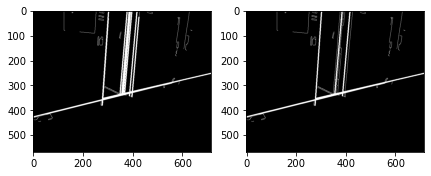

In [80]:
import numpy as np

def get_angle(line):
    x1, y1, x2, y2 = line[0]
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

def get_midpoint(line):
    x1, y1, x2, y2 = line[0]
    return ((x1 + x2) / 2, (y1 + y2) / 2)

def get_line_length(line):
    x1, y1, x2, y2 = line[0]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def distance_between_points(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def filter_lines(lines, angle_threshold, dist_threshold):
    filtered_lines = []
    used = [False] * len(lines)

    for i in range(len(lines)):
        if not used[i]:
            max_length = get_line_length(lines[i])
            selected_line = lines[i]
            angle_i = get_angle(lines[i])
            midpoint_i = get_midpoint(lines[i])
            used[i] = True

            for j in range(i + 1, len(lines)):
                if not used[j]:
                    angle_j = get_angle(lines[j])
                    if abs(angle_i - angle_j) <= angle_threshold:
                        midpoint_j = get_midpoint(lines[j])
                        if distance_between_points(midpoint_i, midpoint_j) < dist_threshold:
                            length = get_line_length(lines[j])
                            if length > max_length:
                                selected_line = lines[j]
                                max_length = length
                            used[j] = True
            filtered_lines.append(selected_line)

    return filtered_lines


blur = cv2.GaussianBlur(test_gray, (5, 5), 0) 
edge = auto_canny_otsu(blur)
lines = cv2.HoughLinesP(edge, 1, np.pi/180, 100, minLineLength=300,
                       maxLineGap=150)

angle_threshold = 10  # 각도 임계
dist_threshold = 20   # 거리 임계
filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)

window = edge.copy()

if lines is not None :
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = calculate_angle(x1, y1, x2, y2)               
        if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
            cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
        else :
            cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)

plt.figure(figsize=(7, 7))
            
plt.subplot(1,2,1)
plt.imshow(window,cmap='gray')


window = edge.copy()

if filtered_lines is not None :
    for line in filtered_lines:
        x1, y1, x2, y2 = line[0]
        angle = calculate_angle(x1, y1, x2, y2)               
        if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
            cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
        else :
            cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)

plt.subplot(1,2,2)
plt.imshow(window,cmap='gray')

print(len(lines), len(filtered_lines))


55.0 110.0


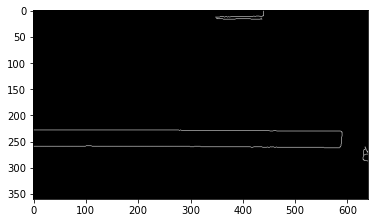

In [81]:
cap = cv2.VideoCapture("./data/edgetest/light_flash.mp4")
_, frame = cap.read()
frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(frame_gray, 5) 
edge = auto_canny_otsu(blur)
plt.imshow(edge, cmap='gray')

In [82]:

cap1 = cv2.VideoCapture("./data/edgetest2/light2.mp4")
cap2 = cv2.VideoCapture("./data/edgetest2/light3.mp4")


angle_threshold = 20  # 각도 임계
dist_threshold = 50   # 거리 임계

# fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' 코덱 사용
# out = cv2.VideoWriter('hough_test.mp4', fourcc, 30.0, (640*2, 360))

while cap2.isOpened() : 
    ret, frame2 = cap2.read()
    ret, frame1 = cap1.read()
    
    
    if not ret :
        break
    frame2 = cv2.resize(frame2, (0, 0), fx=0.5, fy=0.5)
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        
    blur = cv2.medianBlur(frame2_gray, 3) 
    edge = auto_canny_otsu(blur)
    lines2 = cv2.HoughLinesP(edge, 1, np.pi/180, 100, minLineLength=200,
                           maxLineGap=200)
    
    frame1 = cv2.resize(frame1, (0, 0), fx=0.5, fy=0.5)
    frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        
    blur = cv2.medianBlur(frame1_gray, 3) 
    edge = auto_canny_otsu(blur)
    lines1 = cv2.HoughLinesP(edge, 1, np.pi/180, 100, minLineLength=200,
                           maxLineGap=200)
    
    window1 = frame1.copy()
    window2 = frame2.copy()
    
    if lines1 is not None :
        filtered_lines = filter_lines(lines1, angle_threshold, dist_threshold)
        
    if filtered_lines is not None :
        for line in filtered_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)               
            if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
                cv2.line(window1, (x1, y1), (x2, y2), (0, 255, 0), 3)
            else :
                cv2.line(window1, (x1, y1), (x2, y2), (255,0, 0), 3)
    
    if lines2 is not None :
#         for line in lines:
#             x1, y1, x2, y2 = line[0]
#             angle = calculate_angle(x1, y1, x2, y2)               
#             if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
#                 cv2.line(window0, (x1, y1), (x2, y2), (0, 255, 0), 3)
#             else :
#                 cv2.line(window0, (x1, y1), (x2, y2), (255,0, 0), 3)
        filtered_lines = filter_lines(lines1, angle_threshold, dist_threshold)
#     window = cv2.cvtColor(window, cv2.COLOR_GRAY2BGR)
    if filtered_lines is not None :
        
        for line in filtered_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)               
            if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
                cv2.line(window2, (x1, y1), (x2, y2), (0, 255, 0), 3)
            else :
                cv2.line(window2, (x1, y1), (x2, y2), (255,0, 0), 3)
    result = cv2.hconcat([window1, window2])
    cv2.imshow("Drawing HoughLines", result)
#     out.write(result)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
        
cap2.release()
cv2.destroyAllWindows()
# out.release()

41.0 82.0
48.5 97.0
41.0 82.0
48.5 97.0
41.0 82.0
48.5 97.0
41.0 82.0
48.5 97.0
41.0 82.0
48.5 97.0
41.0 82.0
48.5 97.0
41.0 82.0
49.0 98.0
41.0 82.0
49.0 98.0
41.0 82.0
49.0 98.0
41.0 82.0
48.5 97.0
41.0 82.0
48.5 97.0
41.0 82.0
48.5 97.0
41.5 83.0
49.0 98.0
41.5 83.0
49.0 98.0
41.5 83.0
49.0 98.0
41.5 83.0
48.5 97.0
41.5 83.0
48.5 97.0
42.0 84.0
48.5 97.0
42.0 84.0
48.5 97.0
42.0 84.0
48.5 97.0
42.0 84.0
48.5 97.0
42.0 84.0
48.5 97.0
42.5 85.0
48.5 97.0
42.5 85.0
48.5 97.0
42.5 85.0
48.0 96.0
42.5 85.0
48.5 97.0
42.5 85.0
48.5 97.0
42.5 85.0
48.5 97.0
42.5 85.0
48.5 97.0
42.5 85.0
48.5 97.0
42.5 85.0
48.5 97.0
43.0 86.0
48.5 97.0
42.5 85.0
48.5 97.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0
43.0 86.0
48.5 97.0
43.0 86.0
48.5 97.0
42.5 85.0
48.0 96.0
43.0 86.0
48.5 97.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0
43.0 86.0
48.0 96.0


## Logitec Cam

In [83]:
cap = cv2.VideoCapture(1)
ret, frame = cap.read()
plt.imshow(frame)

KeyboardInterrupt: 

In [ ]:
frame.shape

In [ ]:
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(frame_gray, (3, 3), 0) 
edge = auto_canny_otsu(blur)
lines = cv2.HoughLinesP(edge, 1, np.pi/180, 100, minLineLength=200,
                       maxLineGap=100)

angle_threshold = 10  # 각도 임계
dist_threshold = 20   # 거리 임계
filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)

window = edge.copy()

if lines is not None :
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = calculate_angle(x1, y1, x2, y2)               
        if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
            cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
        else :
            cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)

plt.figure(figsize=(7, 7))
            
plt.subplot(1,2,1)
plt.imshow(window,cmap='gray')


window = edge.copy()

if filtered_lines is not None :
    for line in filtered_lines:
        x1, y1, x2, y2 = line[0]
        angle = calculate_angle(x1, y1, x2, y2)               
        if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
            cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
        else :
            cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)

plt.subplot(1,2,2)
plt.imshow(window,cmap='gray')

print(len(lines), len(filtered_lines))

In [ ]:
cap = cv2.VideoCapture(1)


angle_threshold = 20  # 각도 임계
dist_threshold = 50   # 거리 임계

# fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' 코덱 사용
# out = cv2.VideoWriter('hough_test.mp4', fourcc, 30.0, (640*2, 360))

while cap.isOpened() : 
    ret, frame = cap.read()
    
    if not ret :
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(frame_gray, 3) 
    edge = auto_canny_otsu(blur)
    lines = cv2.HoughLinesP(edge, 1, np.pi/180, 100, minLineLength=200,
                           maxLineGap=200)
    window = frame.copy()
    
    if lines is not None :
        filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
        
    if filtered_lines is not None :
        for line in filtered_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)               
            if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
                cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
            else :
                cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)

    cv2.imshow("Drawing HoughLines", window)
#     out.write(result)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap2.release()
cv2.destroyAllWindows()
# out.release()

## 영상 2개 밝/어둡 찍어서 평균 recall/precision 비교도 해보면 조케ㅆ다